# Leaf Classification

### Project Topic
In this project I will be designing a model to classify 99 species of plants, the means of classifying these plants is their leaves which can uniquely distinguinsh one plant from other. The learning algorithms used in this project will be multi-class classificaition algorithms like KNN and AdaBoost.
If done right the ability to classify plant is a crucial one as there are nearly half a million species of plants in the world and one can easily be misclassified as other in this variety, sometimes leading to severe consequences. My goal in this project will be to take a small step towards contributing to the classification of plant species by leveraging ML.

### Github Repository

https://github.com/jagrat89/LeafClassification

## Imports

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import math
import numpy as np
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


## Data

### Data Source

This dataset has been used from the Kaggle Competition for [Leaf Classification](https://www.kaggle.com/competitions/leaf-classification/overview).

### Data Description
The dataset is provided with jpg images of 1,584 leaves specimen, and a corresponding tabulated data contains a row for a each provided image. The tabulated data has been divided in train set and test set, the train set has 990 rows out of the total 1,548, the test set has the rest. The test set has been provided for generating predictions and submiting them in kaggle, for this project I won't be using the test set. As stated above, the plant species can be identified by measuring diffrent features of their leaves, the data measures three features of a leaf __margin__, __shape__ and __texture__. Each feature is measured in a 64-attribute vector for each sample, and these vector have a column for each attribute. The 64-attribute vector for maring is measured in __fine-scaled margin histogram__, fine-scale suggests that the features captured are at a higher resolution or granularity, the term histogram indicates that these fine-scale feature are aggregated into some form of frequency-count. The 64 attribute vector for shape feature is measured as __shape-contiguous descriptor__, the term "contiguous" descriptor implies that the features are derived in a manner that considers the continuity or adjacency of points or segments on the leaf's boundary.  The 64 attribute vector for texture is measured as __interior texture histogram__, the term  texture refers  refers to the visual patterns of pixel intensities in a specified region, the term "interior" suggests that this texture analysis is focused on the main body or inner part of the leaf, excluding the edges or margins. The features margin, shape and texture have 64 columns associated to it from margin1-64 same is true for shape and texture, take a look below for explanation. 

- __id__ : Which refers to an image in the images folder, provided in the dataset.
- __species__ : Contains the name of the species the specific leaf belongs to.
- __margin1-64__ : This feature is described as a vector for each leaf in the dataset, this feature as the name suggest captures the measurement of margins of the leaf, and is divided up as 64 columns from 1 to 64.
- __shape1-64__ : This feature captures the shape of the leaf and has 64 columns for it in the data set.
- __texture1-64__: This feature captures the texture of the image and has 64 columns to represent it for each leaf.

### Reading the Data 

In [34]:
dataset = pd.read_csv("train.csv")

### Brief look of the data

In [210]:
dataset.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


### The info of data set
The data set has 194 columns and 990 rows. Out of 194 columns the features of the leaf which in total 192 columns are float64 ,one column which is an int represents the id of the leaf image, and one column is string which states the species of plant the leaf belongs to. The dataset is 1.5+ MB in size.

In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


### Checking for any NA/NULL values in the dataset

There are no NA/NULL values in the dataset.

In [213]:
True in dataset.isna().any()

False

## Data Cleaning

### Checking if distribution of diffrent species in the data set is balanced

Each of the 99 species have 10 sampels in the training data. The distribution of the classes in the dataset is balanced.

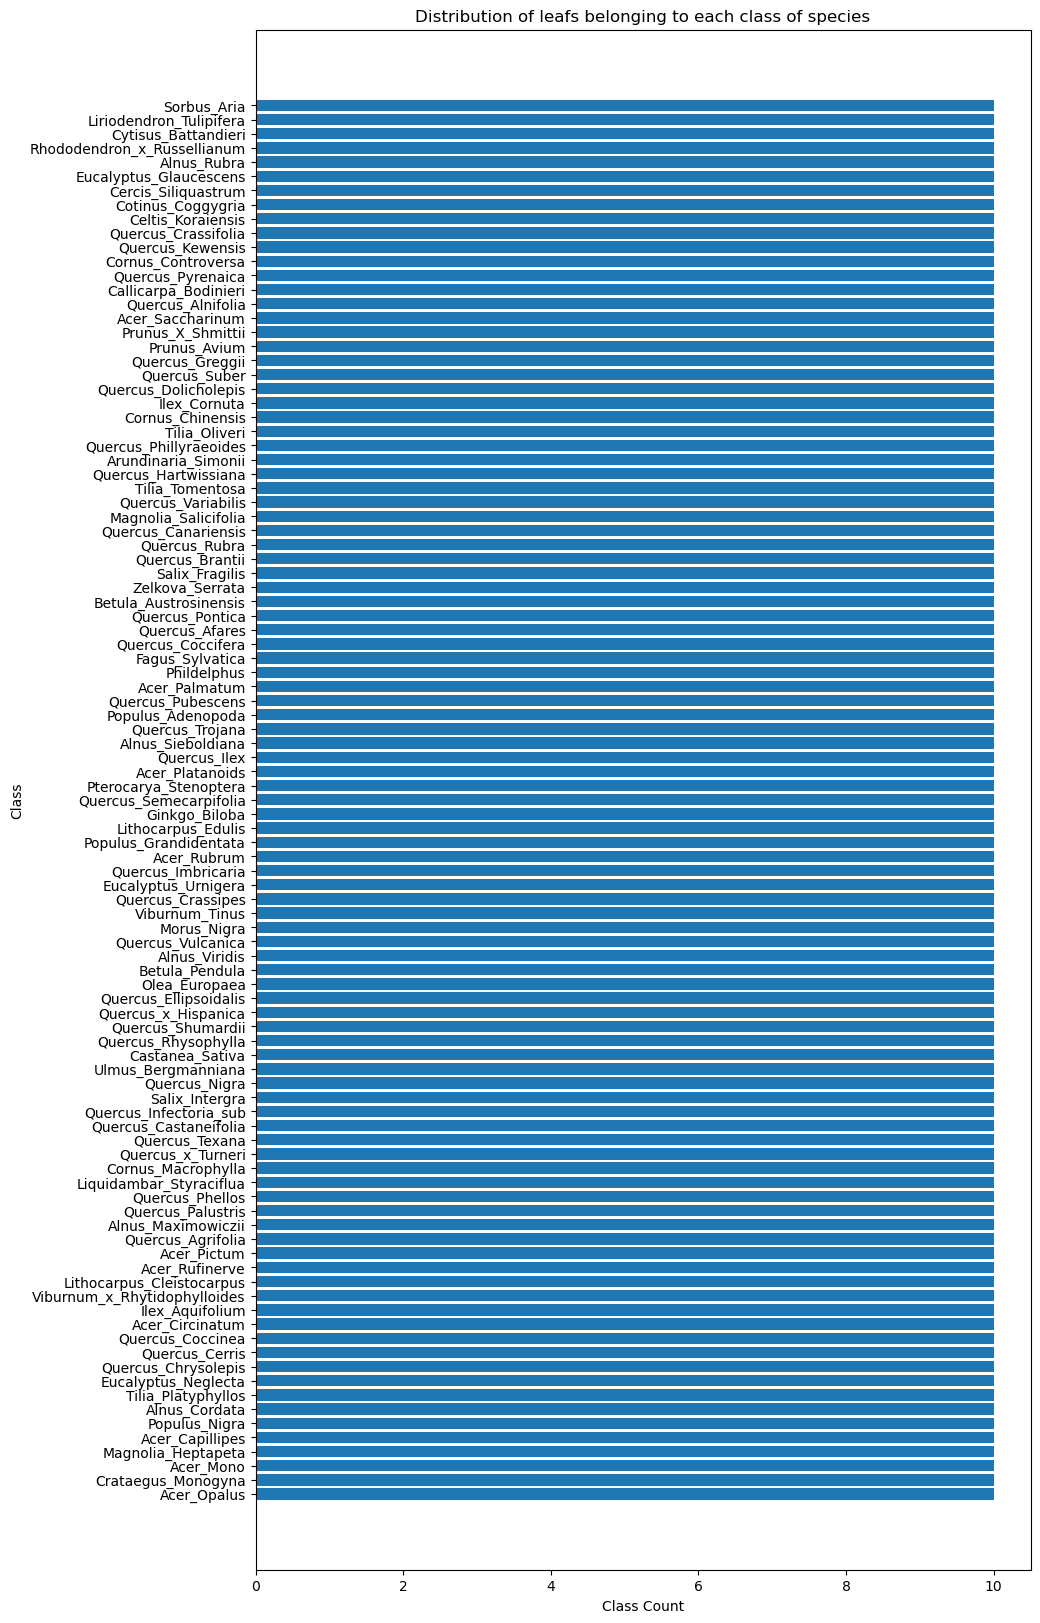

In [333]:
species_count = dataset['species'].value_counts()
plt.figure(figsize=(10, 20))

plt.barh(species_count.index, species_count.values)
plt.xlabel('Class Count')
plt.ylabel('Class')
plt.title(f'Distribution of leafs belonging to each class of species')
plt.show()

### Data Cleaning Task to perform

As there are no NA or NULL values in the dataset and the dataset is balanced, there is not much cleaning to do, there are two task to perform, 
1. Drop the id column
2. Create a separate df for the traget variable which is the species column.

### The images of leaves refered in the __id__ cloumn of the dataset

Before I remove the id column, let's visualize the images the rows refer to.

In [12]:
def plot_images_grid(images):
    fig, axs = plt.subplots(3, 5, figsize=(10,10))

    for i, ax in enumerate(axs.ravel()):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

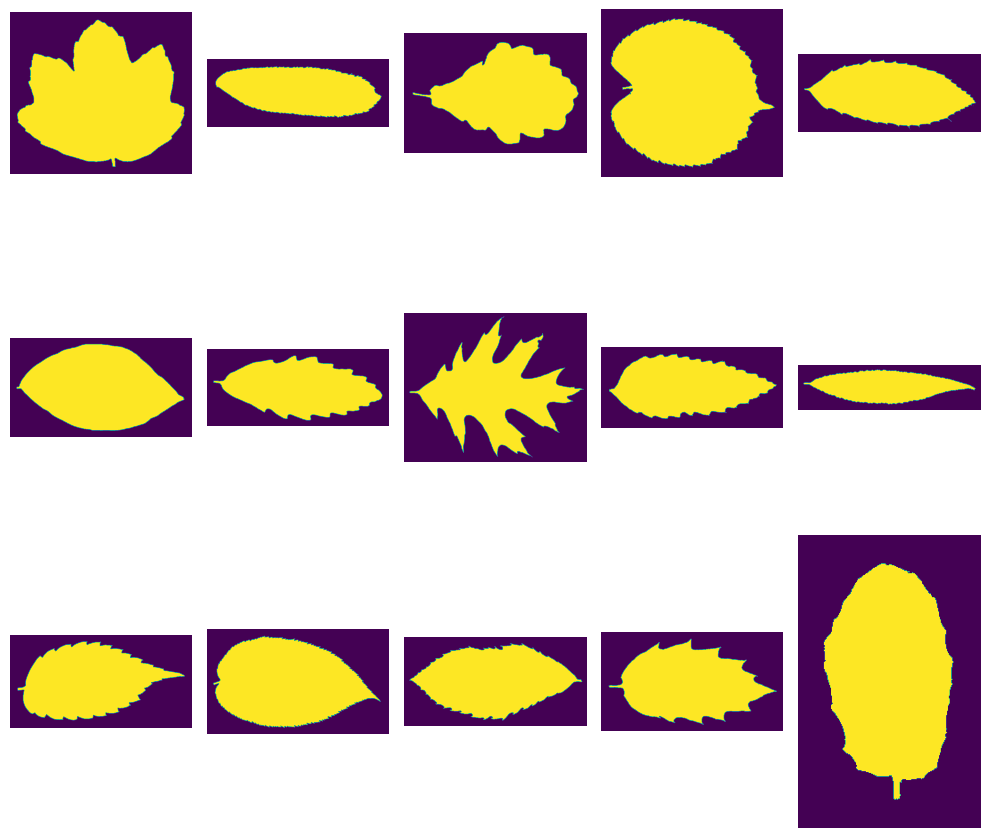

In [38]:
folder_name = 'images/'
leaf_images = [imread(folder_name + str(f) + '.jpg') for f in dataset['id']]
plot_images_grid(leaf_images)

### Dropping id column and Creating separate df for species and the predictors
I will drop the id column which contains the id of the corresponding image in the images folder.

In [214]:
X = dataset.drop(columns = ["species", "id"])
y = dataset["species"]

### Summary of the X df

The df rightly contains 192 columns which is the vector attributes of the margin, shape and texture features.

In [215]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 192 entries, margin1 to texture64
dtypes: float64(192)
memory usage: 1.5 MB


### Summary of the y target df

In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 990 entries, 0 to 989
Series name: species
Non-Null Count  Dtype 
--------------  ----- 
990 non-null    object
dtypes: object(1)
memory usage: 7.9+ KB


### Summary For Data Cleaning

In the data cleaning section I dropped the __id__ column which had the names of the corresponding jpg images of the leaves, and created a new df for the predictors ( X ) and target ( y ) variables in the dataset.

## EDA and Visualization

### Calculating Margin feature Statistics

For starter let's take a look at the margin values and how they are distributed. I will take a mean and variance across all the features of margin from 1 to 64.

In [223]:
margin_df = X[[f"margin{m}" for m in range(1,65)]]
margin_means = np.mean(margin_df, axis = 0)
margin_var = np.var(margin_df, axis = 0)

### Visualising the stats for Margin feature

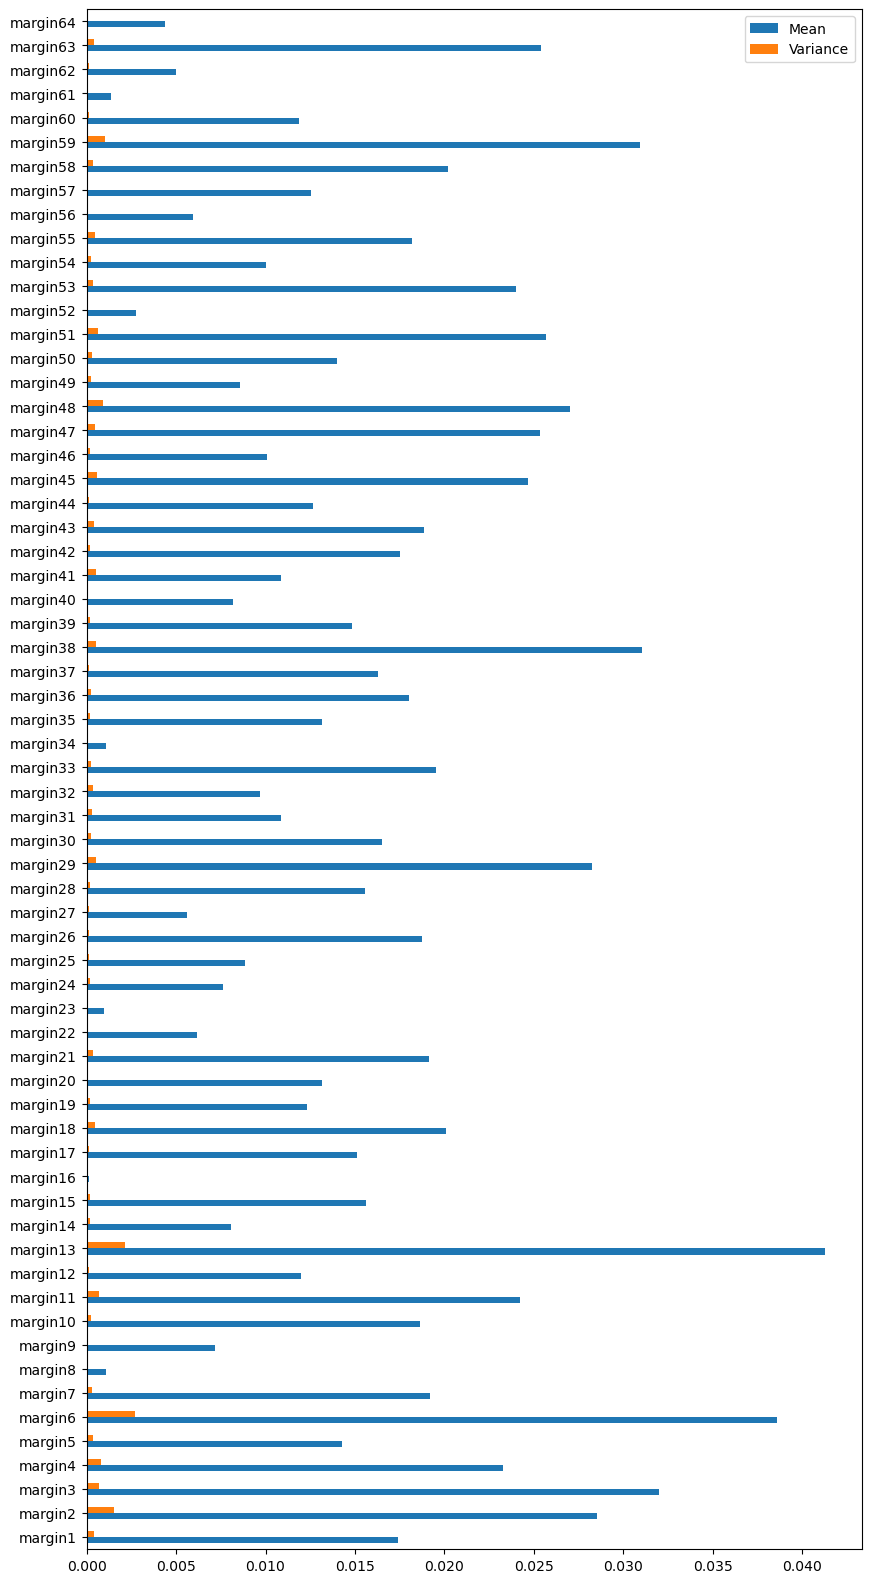

In [233]:
sm_data = {'Mean': margin_means,
        'Variance': margin_var}
p_df = pd.DataFrame(sm_data,columns=['Mean', 'Variance'], index = [f"margin{m}" for m in range(1,65)])

p_df.plot.barh(figsize=(10, 20))

plt.show()

#### Plot Analysis
As per the visualization the mean of each of the margin feature vary highly but the variance for each feature is relatively low, which means that the distribution of the feautres is clustered around the mean.

### Calculating Shape feature Statistics

Now let's take a look at the shape values and how they are distributed. I will take a mean and variance across all the features of shape from 1 to 64.

In [236]:
shape_df = X[[f"shape{m}" for m in range(1,65)]]
shape_means = np.mean(shape_df, axis = 0)
shape_var = np.var(shape_df, axis = 0)

### Visualising the stats for Shape feature

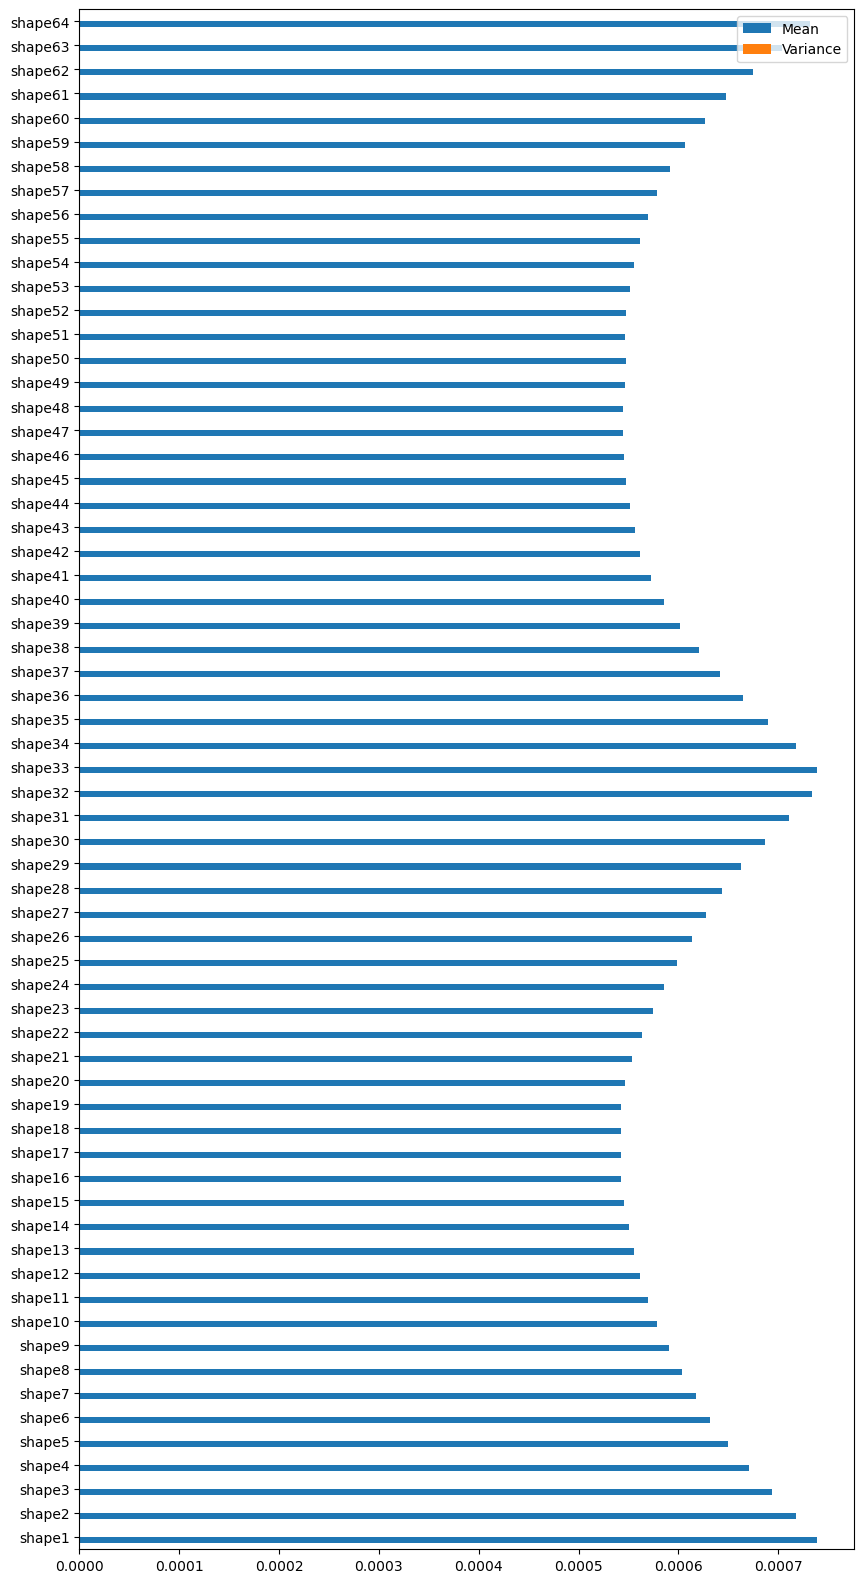

In [237]:
ss_data = {'Mean': shape_means,
        'Variance': shape_var}
s_df = pd.DataFrame(ss_data,columns=['Mean', 'Variance'], index = [f"shape{m}" for m in range(1,65)])

s_df.plot.barh(figsize=(10, 20))

plt.show()

#### Plot Analysis
This visualization highlighs a very intersting pattern, the values below and above the feature shape 33 have the same mean and hence creating a symmetrical pattern, and another interesting observation is the low variance in each feature, the variance is lower than 0.000, this is useful information which can be used in further modeling, by reducing redundant features. The explanation for this observation is, in nature leafs are approximately symmetrical on both sides and the shape values capture one side with 32 values and other with 32 values, which produces similar results.

### Calculating Texture feature Statistics

In [241]:
texture_df = X[[f"texture{m}" for m in range(1,65)]]
texture_means = np.mean(texture_df, axis = 0)
texture_var = np.var(texture_df, axis = 0)

### Visualising the stats for Texture feature

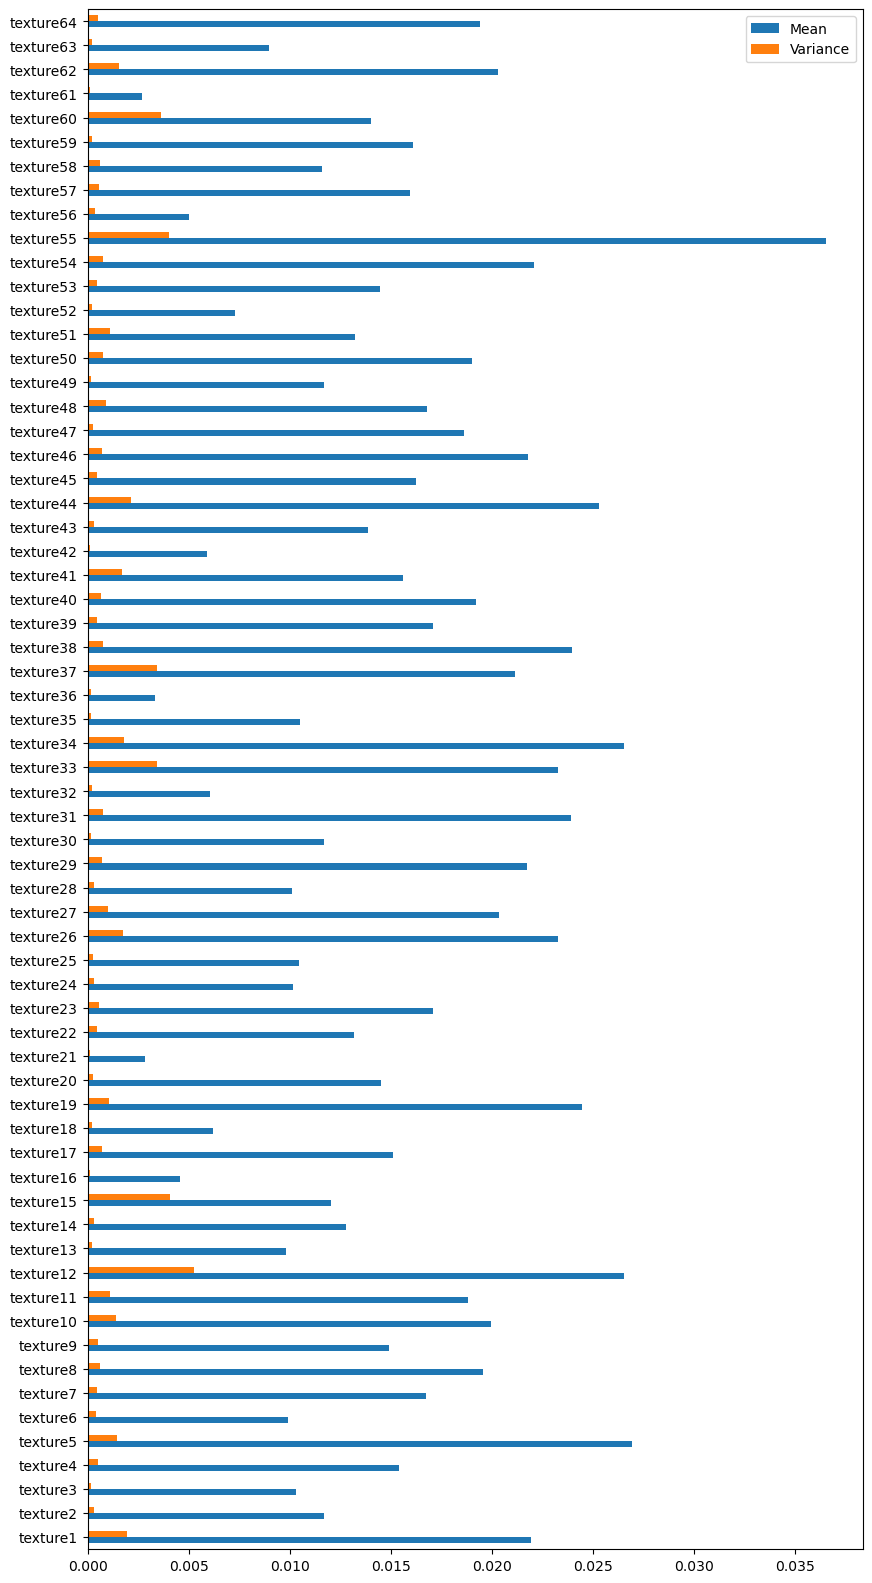

In [242]:
ts_data = {'Mean': texture_means,
        'Variance': texture_var}
t_df = pd.DataFrame(ts_data,columns=['Mean', 'Variance'], index = [f"texture{m}" for m in range(1,65)])

t_df.plot.barh(figsize=(10, 20))

plt.show()

#### Plot Analysis
This visualization doesn't yield any specific pattern, the observation here is the variance in the texutre features is pretty low overall.

### Correlation Matrix 

As there are 192 features in the dataframe I will only include features which. have more than or equal to 70% correlation in the matrix, otherwise the visualisation will be too huge. I expect to see high correlation between the shape features.

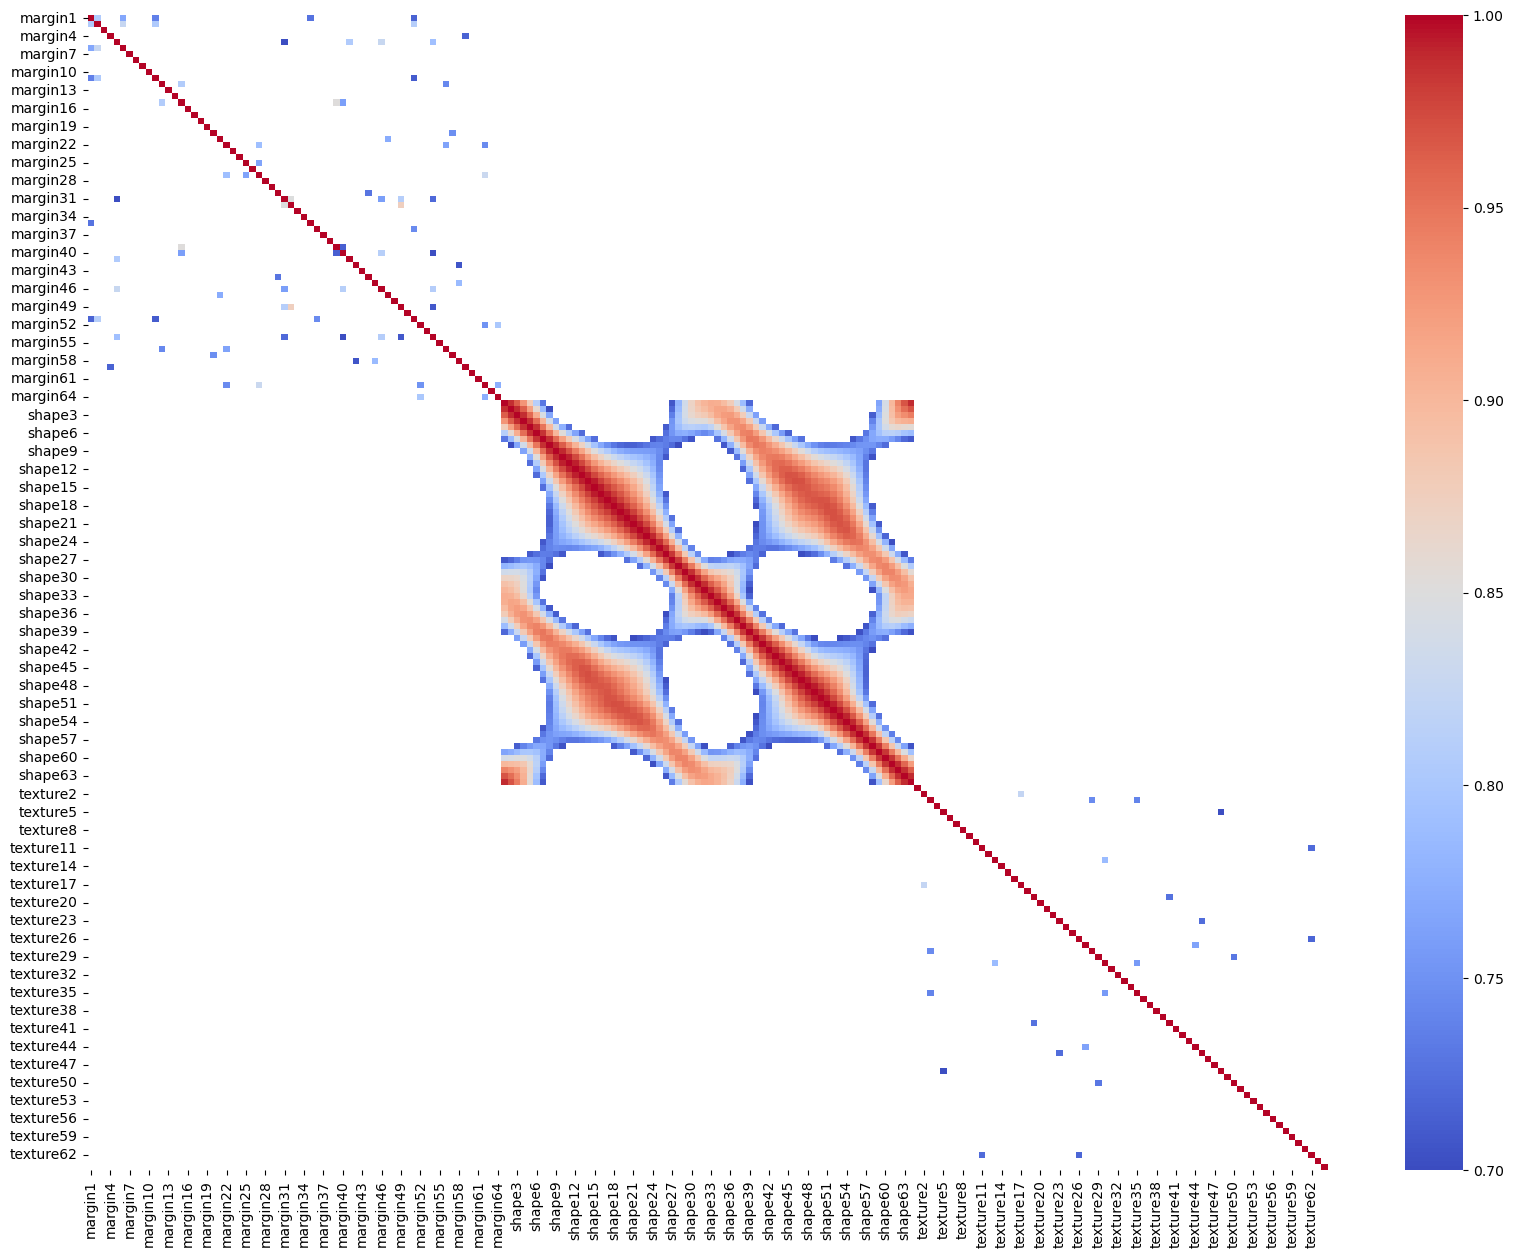

In [262]:
corr = X.corr()

threshold = 0.7
filtered_corr = corr[abs(corr) >= threshold]

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', vmin=0.7, vmax=1)
plt.show()

#### Plot Analysis 

Although it is difficult to look at the corr matrix, we can conclude that the shape, margin and texture features have no correlation between each other. The shape feature as expected has a lot of correlated features, let's look at each of the features correlation matrix independently for better visual and then again analyse the result  

### Margin Correlation Matrix

Plotting the confusion matrix for the margin attribute for correlation greater than __70%__

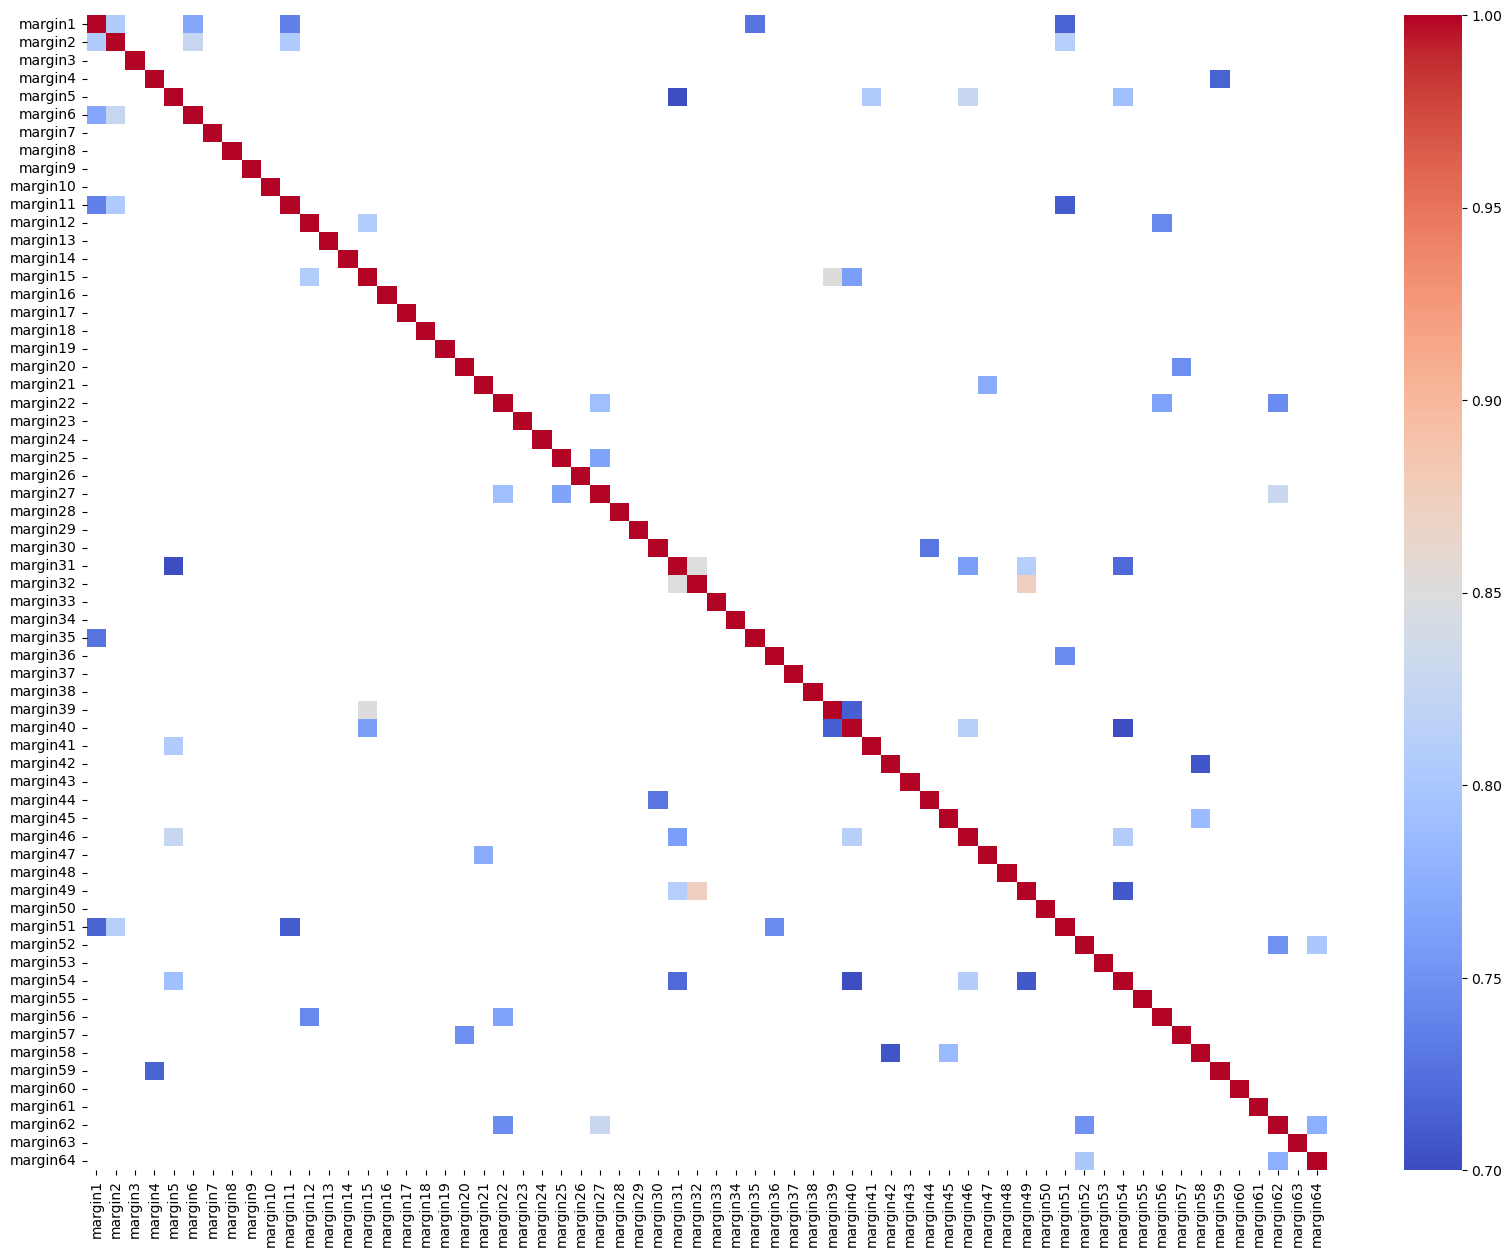

In [261]:
mcorr = margin_df.corr()

threshold = 0.7
filtered_mcorr = mcorr[abs(mcorr) >= threshold]

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_mcorr, annot=False, cmap='coolwarm', vmin=0.7, vmax=1)
plt.show()

#### Plot Analysis

As we can see there are many margin features highly correlated to each other, the reason for this can be due to the fact the the margins are measured in a fine-scale margin histogram, which means it has aggregated all the values in 64 buckets or frequency counts of patterns observed, and the leaf margins at these high correlation spots must be observing similar frequencies, for example showing that these two patterns are correlated.

### Shape Correlation Matrix


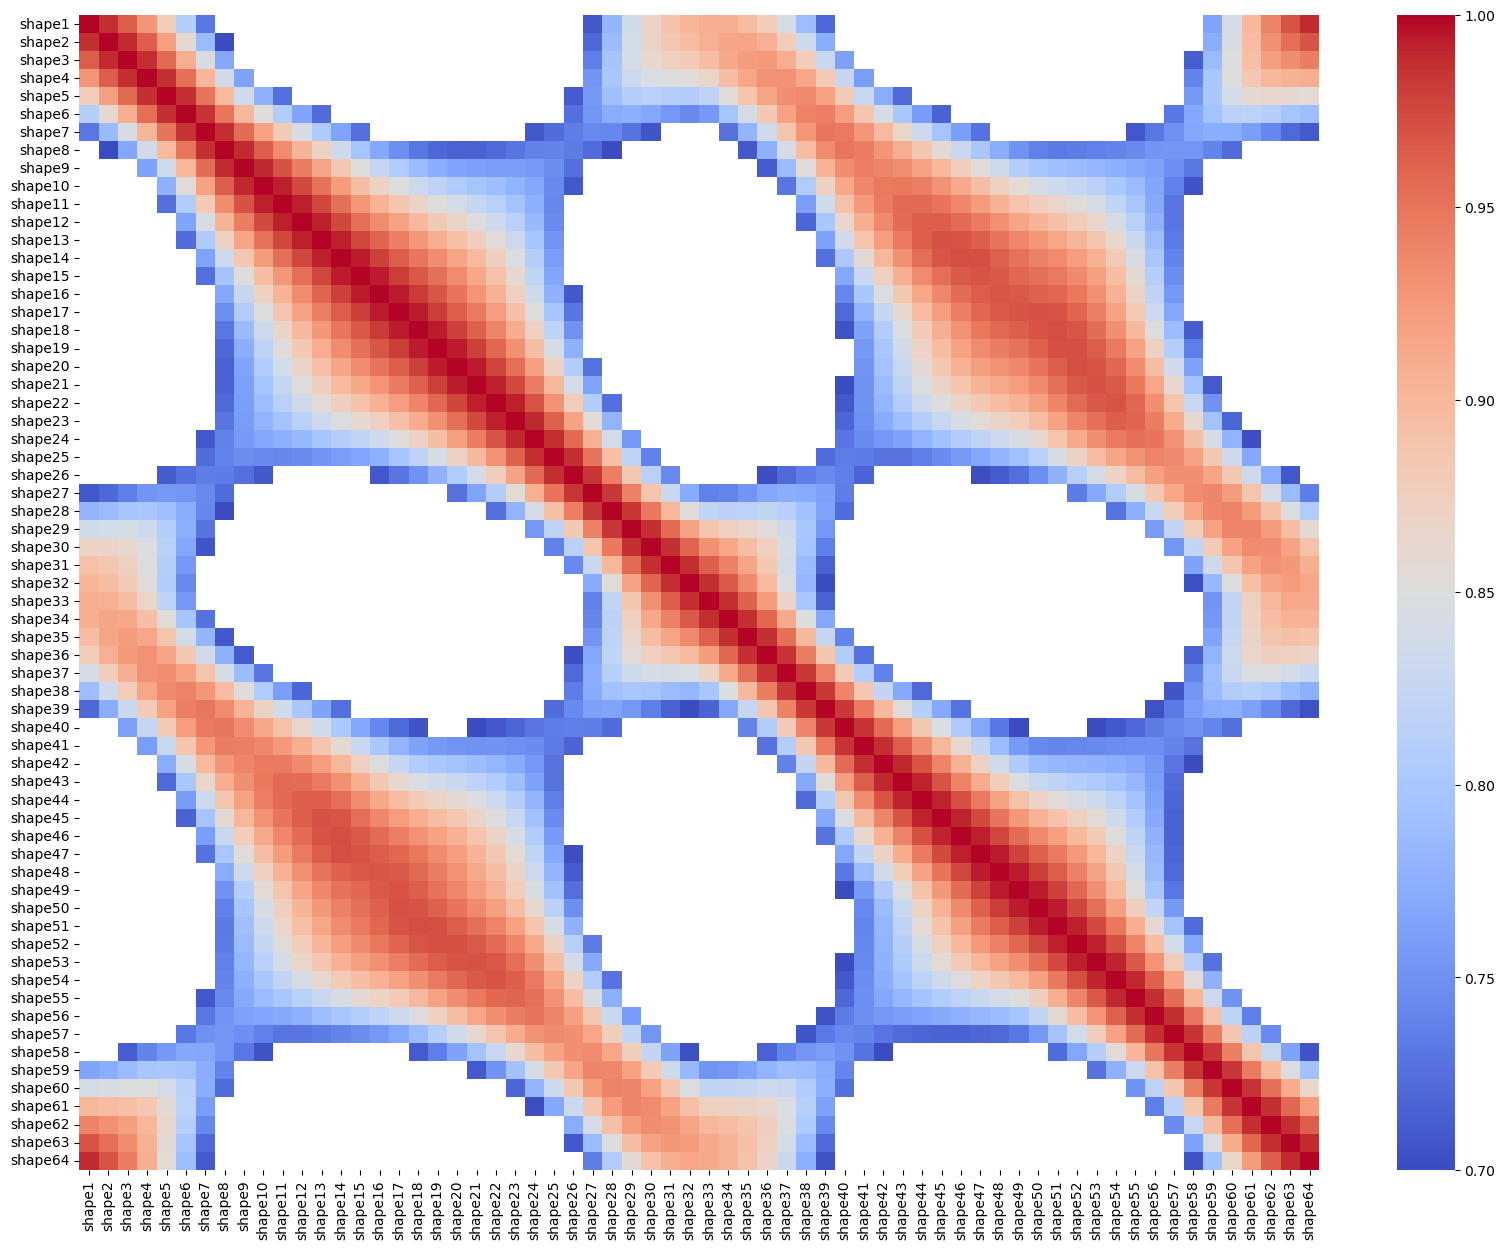

In [253]:
scorr = shape_df.corr()

threshold = 0.7
filtered_scorr = scorr[abs(scorr) >= threshold]

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_scorr, annot=False, cmap='coolwarm', vmin=0.7, vmax=1)
plt.show()

#### Plot Analysis

As observed in the plot for the shape feature distribution, there is a high correlation in the 64 columns capturing the shape vector, it due the approximate symmetry on both sides of a leaf, and as the shape feature describe the shape of the leaf some of them are bound to be highly correlated, and the reason the adjecent shape attributes such as shape1 and shape2, are correlated is due the way they were calculated the shape has been recorded as a shape contigious descriptor which means that is captures continious shape which is naturally bound to be correlated as the points next to each other are not very different.

### Texture Correlation Matrix


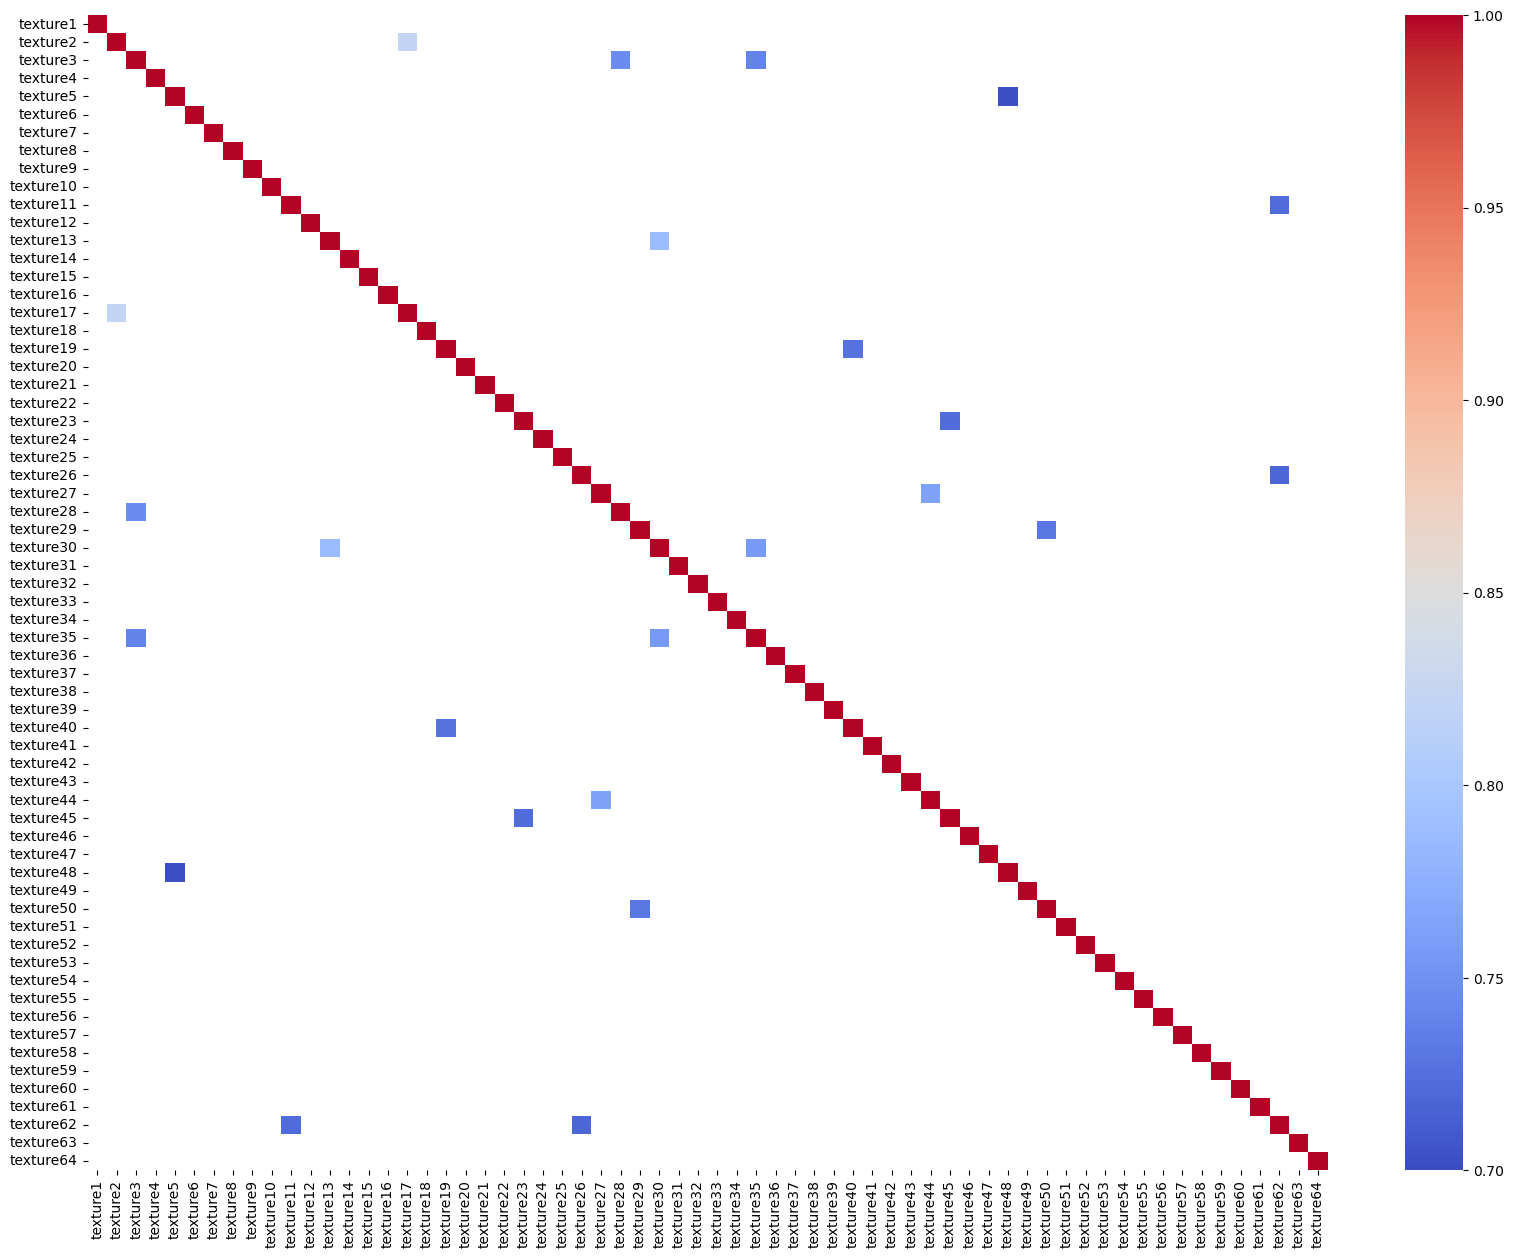

In [258]:
tcorr = texture_df.corr()

threshold = 0.7
filtered_tcorr = tcorr[abs(tcorr) >= threshold]

plt.figure(figsize=(20, 15))
sns.heatmap(filtered_tcorr, annot=False, cmap='coolwarm', vmin=0.7, vmax=1)
plt.show()

#### Plot Analysis

The correlation for texture doesn't seem to follow any specific pattern, but the explanation for this correlation is that the leaf must be naturally observing this specific texture patterns frequently together hence producing a high correlation.

### EDA Summary

In this section I reduced the cardinallity of the margin, shape and texture features for analysis sake by taking the mean across its features and visualised them to check if there was any pattern or specific observation to note, while the margin and texutre features didn't yield any pattern, the shape feature highlighted a pattern that we observe in leaves, which is the symmetry of it's sides. In this section I also created the correlation matrix of the dataset features, as per the correlation matrix there is a lot of correlation between the 64 features of shape, between the 64 features of margin and between a few features of texture, we also looked at the shape, margin and texture features correlation matrix independently for a closer look. 

## Modeling

### Feature Engineering

#### Removing Correlated features from Margin and Texture

I will remove one of the correlated features from margin columns and texture columns which have a threshold above 70%. I will use the correlation matrix computed previously and get the names of the features to drop, for choosing which features to drop the algorithm below is following:
- Extract Use the upper triangle of the correlation matrix
- Check if a pair of features have a correlation higher than 70
- If so check if any of the feature name already exist in the to_drop set
- If not add the second feature to the set
- Repeat for all combination of pairs which satisfy the conditions

In [291]:
# Compute the correlation matrix
abs_mcorr = mcorr.abs()
abs_scorr = scorr.abs()
abs_tcorr = tcorr.abs()

# Get the upper triangle of the correlation matrix
mupper_corr_matrix = abs_mcorr.where(np.triu(np.ones(abs_mcorr.shape), k=1).astype(bool))
tupper_corr_matrix = abs_tcorr.where(np.triu(np.ones(abs_tcorr.shape), k=1).astype(bool))

# Identify columns to drop based on threshold
mto_drop = set()
tto_drop = set()

def columns_to_drop(td, ucrm):
    for i in range(ucrm.shape[0]):
        for j in range(i+1, ucrm.shape[1]):
            if ucrm.iloc[i, j] > threshold:
                colname_i = ucrm.columns[i]
                colname_j = ucrm.columns[j]
                if colname_i not in td and colname_j not in td:
                    td.add(colname_j)

columns_to_drop(mto_drop, mupper_corr_matrix)
columns_to_drop(tto_drop, tupper_corr_matrix)

print(f"List of Margin features to drop \n{mto_drop}")
print(f"List of Texture features to drop \n{tto_drop}")

List of Margin features to drop 
{'margin49', 'margin56', 'margin11', 'margin58', 'margin31', 'margin51', 'margin54', 'margin27', 'margin47', 'margin2', 'margin6', 'margin46', 'margin15', 'margin41', 'margin40', 'margin59', 'margin44', 'margin64', 'margin35', 'margin62', 'margin57'}
List of Texture features to drop 
{'texture30', 'texture45', 'texture40', 'texture48', 'texture28', 'texture50', 'texture17', 'texture62', 'texture44', 'texture35'}


As per the algorithm we have to remove 21 features out of the 64 margin features, and 10 features of 64 texture features.

#### Removing the features from the dataframe

In [299]:
to_drop = list(mto_drop) + list(tto_drop)
feX = X.drop(columns = to_drop)

In [300]:
feX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 161 entries, margin1 to texture64
dtypes: float64(161)
memory usage: 1.2 MB


Now the predictor dataset has 161 columns out of the original 192 columns.

#### Removing symmetrical features from Shape

As per the bar-chart Visualisation of the Shape features, there are a lot of redundant feautres in the shape features, because the features from shape-1 to shape-33 and from shape-33 to shape-64 are approximately symmetrical, we don't have much use of repeating features as they will contribute almost the same information for the model. Based on this premise I will remove all the features from shape features which are above shape-33. Meaning the last 31 features of shape.

In [301]:
feX = feX.drop(columns = [f"shape{i}" for i in range(34,65)])

In [302]:
feX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 130 entries, margin1 to texture64
dtypes: float64(130)
memory usage: 1005.6 KB


After removing the margin, texture and shape features from the dataset we have 130 total features.

### Feature Engineering Summary

For the margin and texture features I removed one out of all the correlated feature pairs having a correlation above 70%, for the shape feature I removed the redundant features which is basically one of the two sides of a leaf.
In total I removed a total of 62 features, which reduced the memory size of the data set to 83% of the original which is a 27% reduction in size.

### Performing the train-test split

First I will keep the test size to 30% of the data.

In [344]:
X_train, X_test, y_train, y_test = train_test_split(feX, y, test_size=0.30, random_state = 5)

### KNN (K-Nearest-Neighbour)

First I will be trying out the non-parameteric KNN Model, with K = 3. 

In [345]:
model1 = KNeighborsClassifier(n_neighbors=3)
model1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Let's see the accuracy of the model on training and test data

In [346]:
print(f"Train Accuracy: {model1.score(X_train, y_train)}")
print(f"Test Accuracy: {model1.score(X_test, y_test)}")

Train Accuracy: 0.924963924963925
Test Accuracy: 0.8013468013468014


The model is overfitting the training data this can be due to the low number of the k parameter. It's performance is not so good at the test data with 83% accuracy

#### Increasing __k__ 

I will increase the value of __k__ to 5, to see if it makes the model performance better.

In [347]:
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X_train, y_train)
print(f"Train Accuracy: {model2.score(X_train, y_train)}")
print(f"Test Accuracy: {model2.score(X_test, y_test)}")

Train Accuracy: 0.8888888888888888
Test Accuracy: 0.7508417508417509


Increasing the k-parameter resulted in model perfromance getting reduced, and is still overfitting.

#### Hypertuning

I will try out many k-parameters with KNN, I will plot the model accuray for all the experiments.

In [478]:
knn_lst = []
train_accuracy = []
test_accuracy = []
for i in range(1, 30,2):
    m = KNeighborsClassifier(n_neighbors=i)
    m.fit(X_train, y_train)
    train_accuracy.append(m.score(X_train, y_train))
    test_accuracy.append(m.score(X_test, y_test))
    knn_lst.append(m)

#### Result

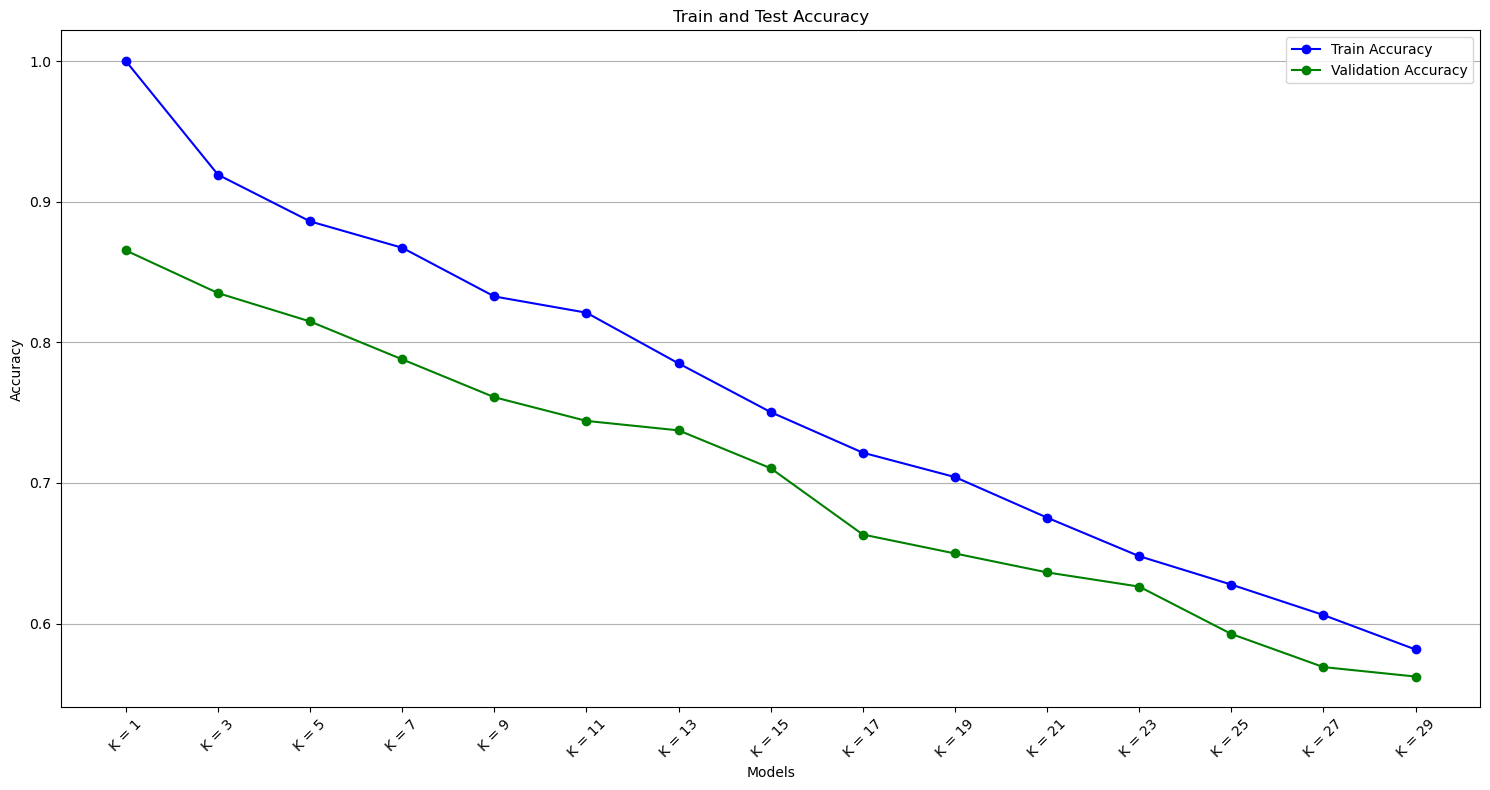

In [479]:
models = [f'K = {i+1}' for i in range(0,30, 2)]

plt.figure(figsize=(15, 8))

plt.plot(models, train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

#### Analysis

It is clear from the plot above there is not much meaning in increasing the k-parameter, as it reduces the performance. Let's check the train and test data for imabalance for distribution of classes in both the sets.

#### Visualising class distribution of species in train and test set

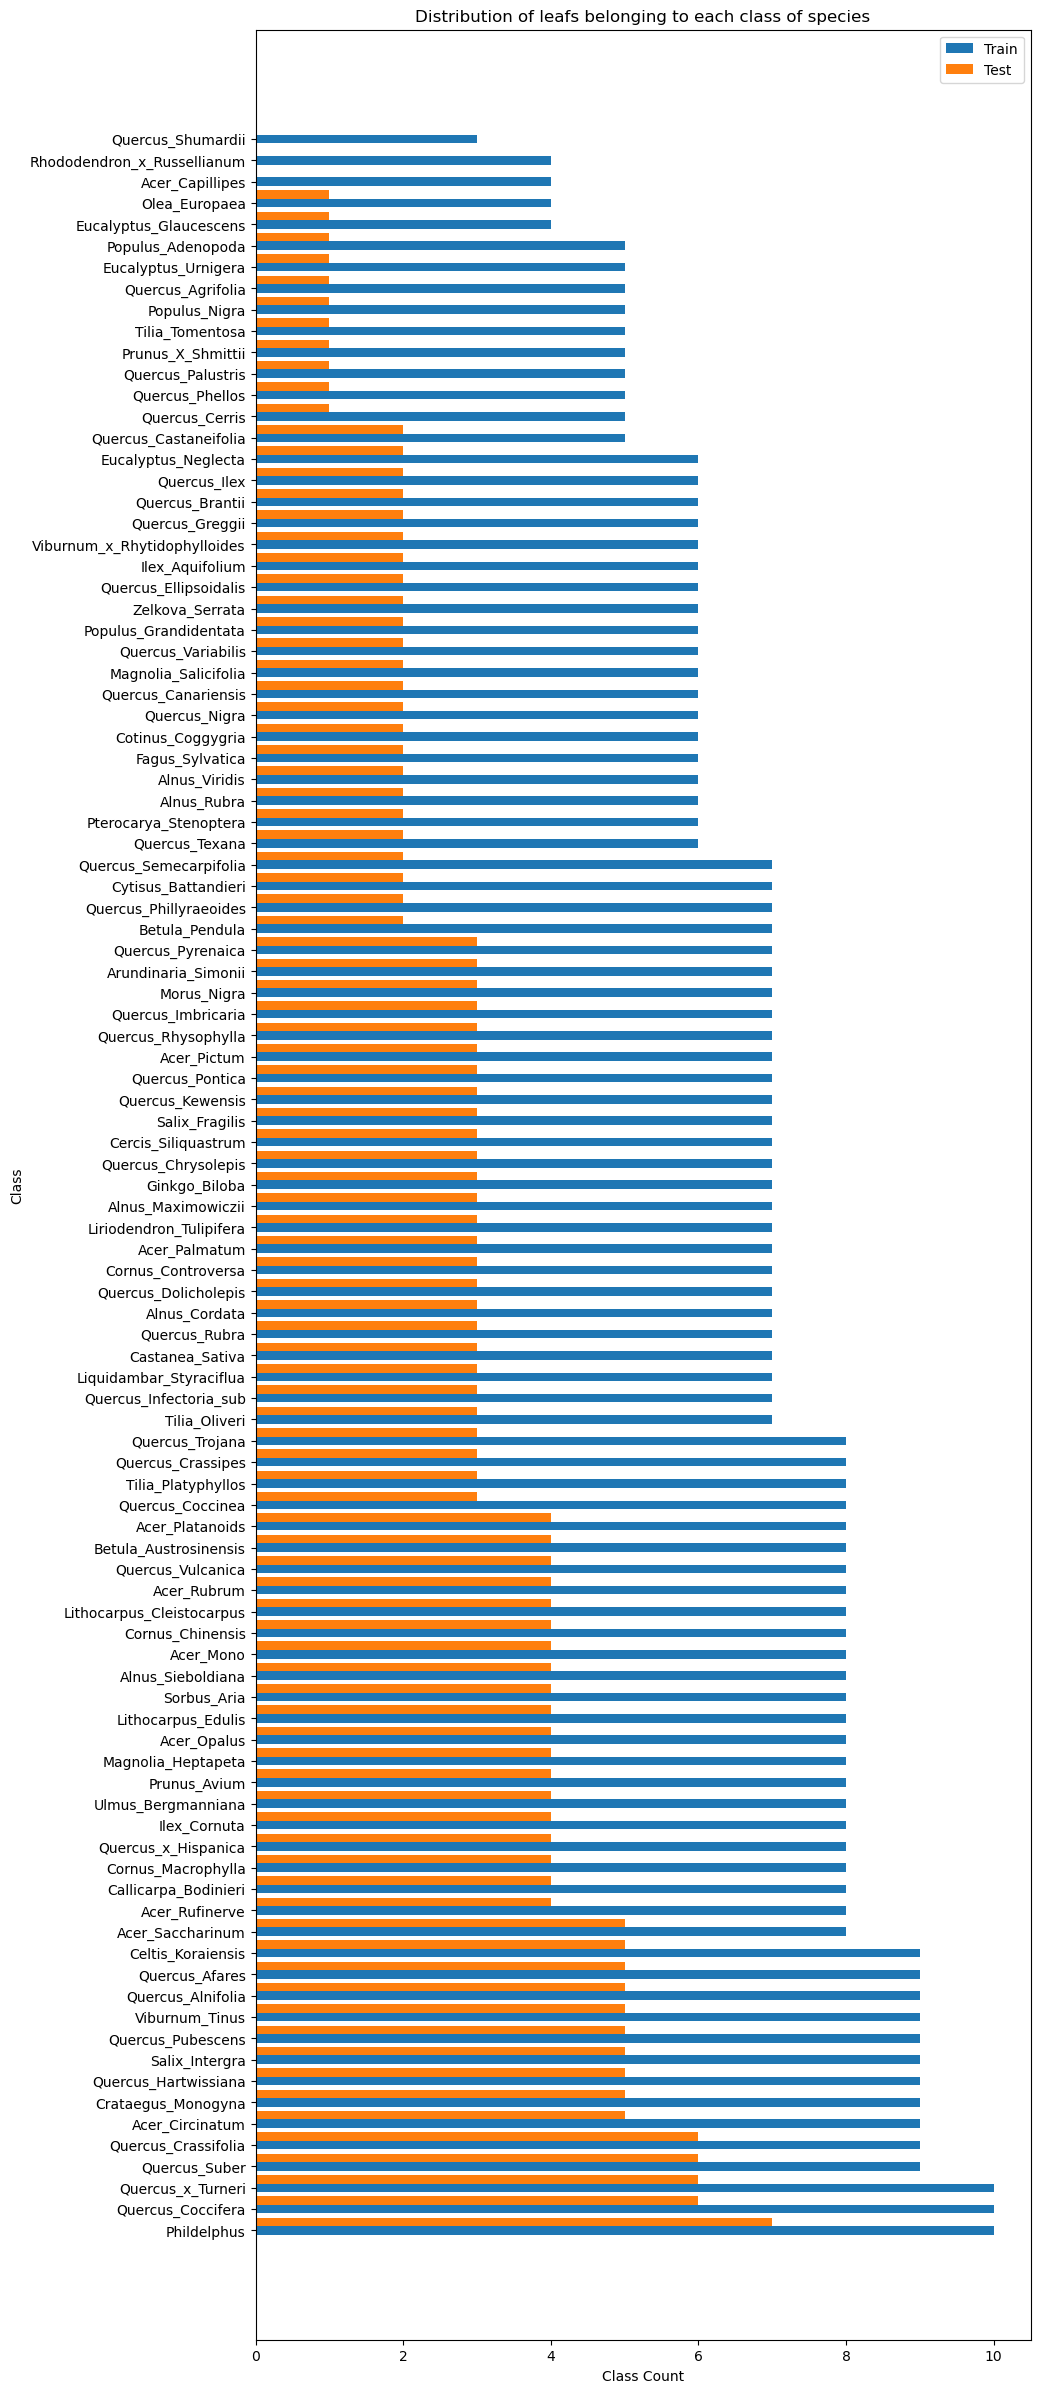

In [334]:
train_species_count = y_train.value_counts()
test_species_count = y_test.value_counts()

width = 0.4  # Set the width of the bars

# Create positions for the bars
train_positions = [i - width/2 for i in range(len(train_species_count))]
test_positions = [i + width/2 for i in range(len(test_species_count))]

plt.figure(figsize=(10, 30))

# Plotting the bars
plt.barh(train_positions, train_species_count.values, height=width, label='Train', color='tab:blue')
plt.barh(test_positions, test_species_count.values, height=width, label='Test', color='tab:orange')

# Setting the y-axis ticks to class names
plt.yticks(ticks=train_positions, labels=train_species_count.index)

plt.xlabel('Class Count')
plt.ylabel('Class')
plt.title(f'Distribution of leafs belonging to each class of species')
plt.legend()

plt.show()


#### Analysis
There is clearly an imbalanced distribution of classes in both the train and test datasets, this is due the train-test split, I will split the dataset again this time keeping them balanced, then get back to training the model.

### Performing balanced train-test split ( Reducing Data __Imbalance__ )

I will keep the test size to 30% and use the stratify parameter to balance the split.

In [484]:
X_train, X_test, y_train, y_test = train_test_split(feX, y, test_size=0.3, random_state=5, stratify=y)

#### Visualising class distribution of species in train and test set

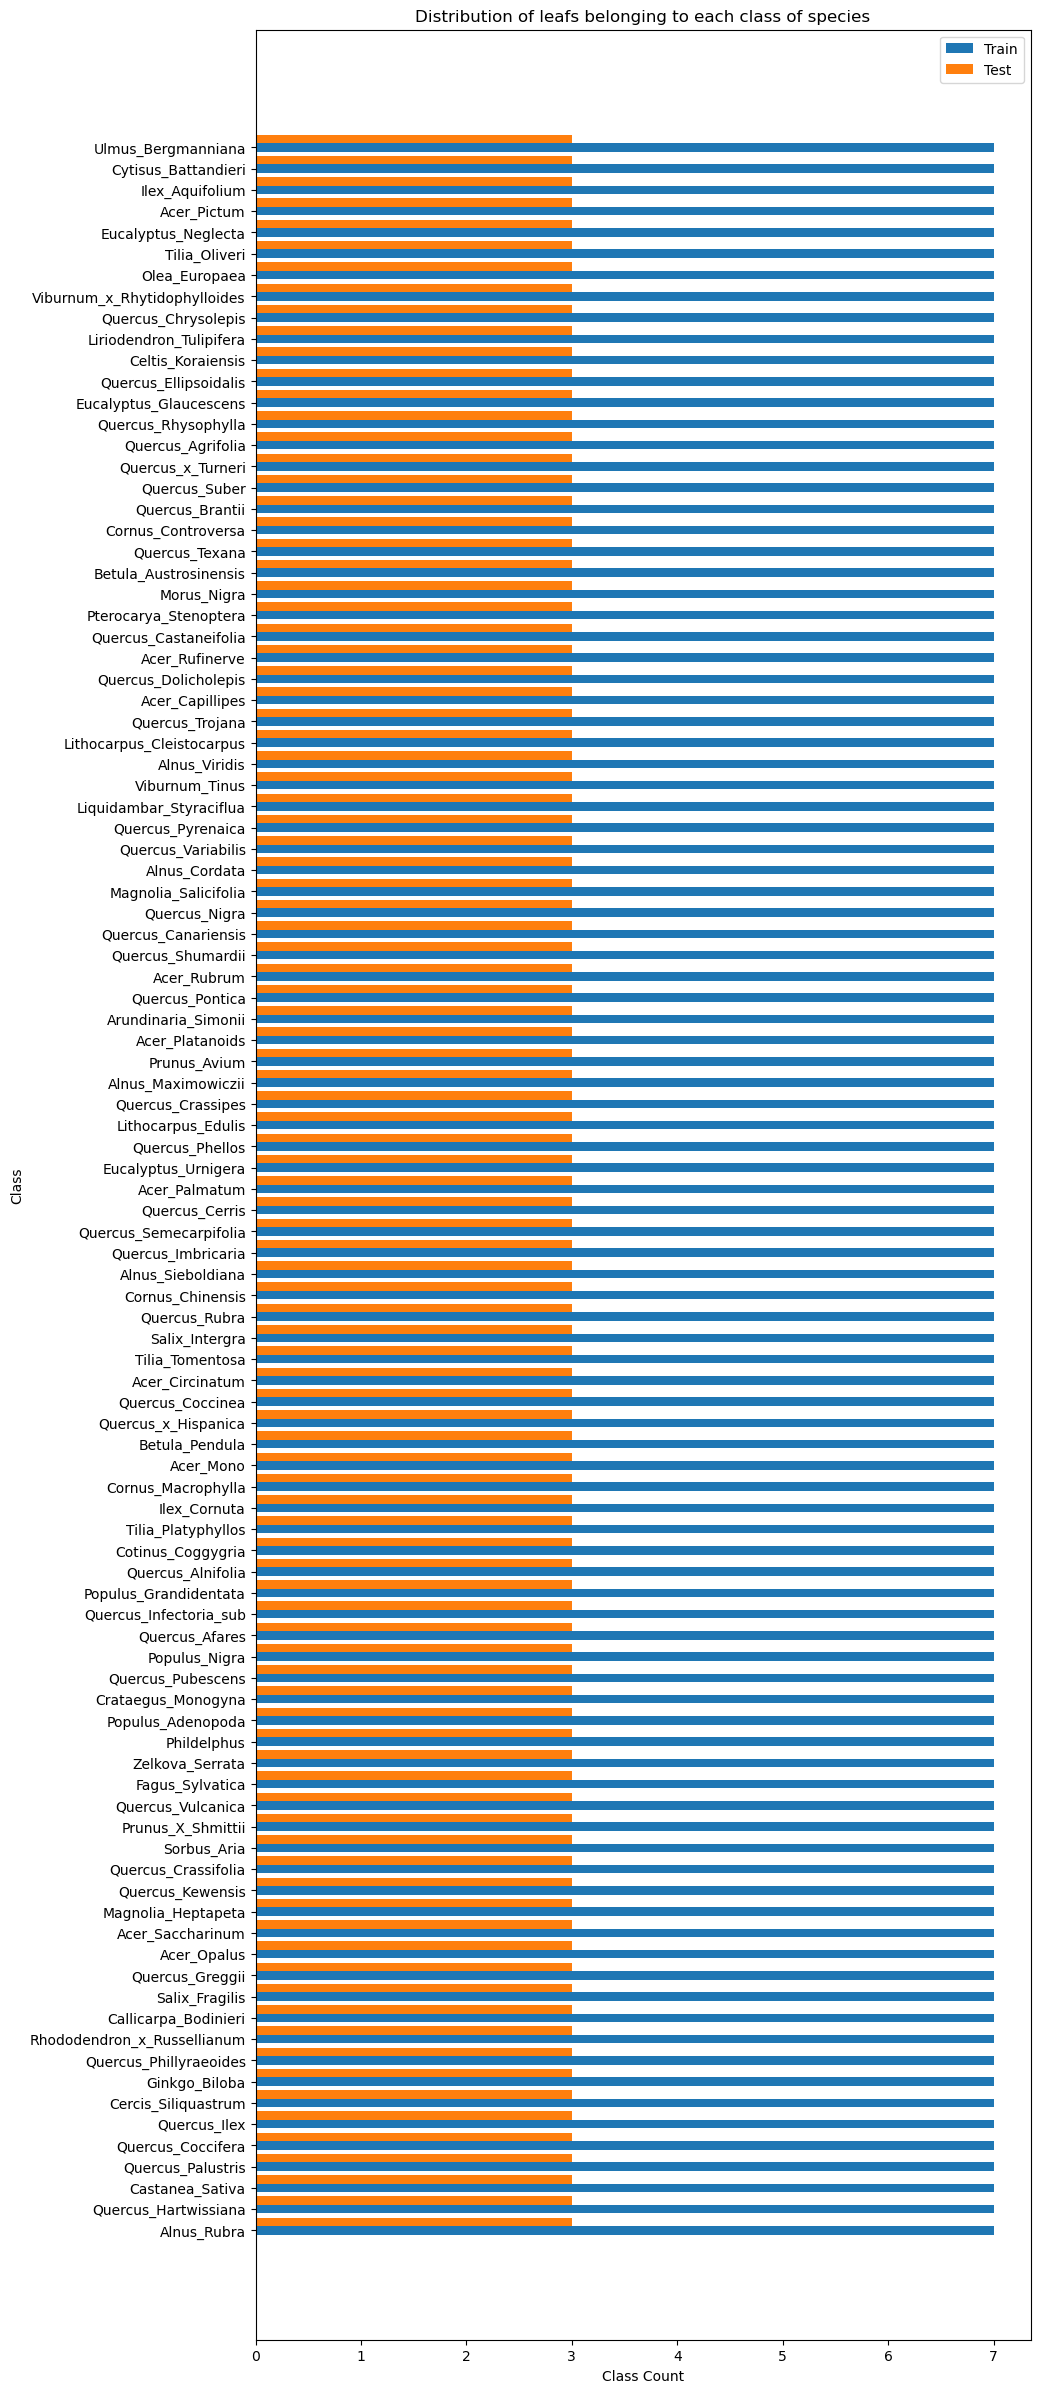

In [481]:
train_species_count = y_train.value_counts()
test_species_count = y_test.value_counts()

width = 0.4 

train_positions = [i - width/2 for i in range(len(train_species_count))]
test_positions = [i + width/2 for i in range(len(test_species_count))]

plt.figure(figsize=(10, 30))

plt.barh(train_positions, train_species_count.values, height=width, label='Train', color='tab:blue')
plt.barh(test_positions, test_species_count.values, height=width, label='Test', color='tab:orange')

plt.yticks(ticks=train_positions, labels=train_species_count.index)

plt.xlabel('Class Count')
plt.ylabel('Class')
plt.title(f'Distribution of leafs belonging to each class of species')
plt.legend()

plt.show()


Now that we have a balanced split let's get back to training the KNN.

### KNN Hypertuning

In [485]:
knn_lst = []
train_accuracy = []
test_accuracy = []
for i in range(1, 30,2):
    m = KNeighborsClassifier(n_neighbors=i)
    m.fit(X_train, y_train)
    train_accuracy.append(m.score(X_train, y_train))
    test_accuracy.append(m.score(X_test, y_test))
    knn_lst.append(m)

#### Result

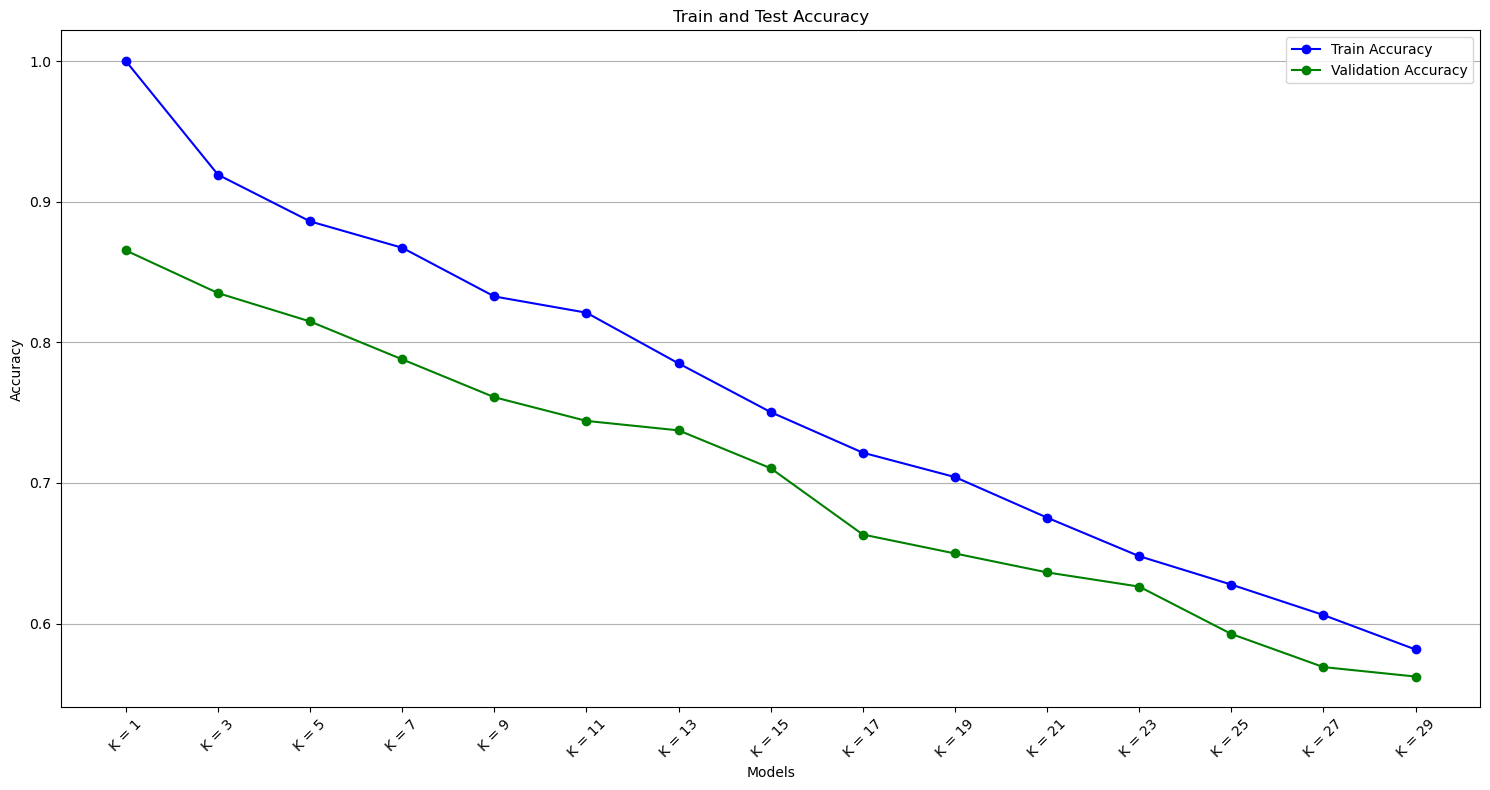

In [486]:
models = [f'K = {i+1}' for i in range(0,30, 2)]

plt.figure(figsize=(15, 8))

plt.plot(models, train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

Creating a balanced train/test split has resulted in an increase of test accuracy, let's take a look at the best KNN model so far which is KNN with k = 1. 

#### KNN with k = 3

We get a higher Test Accuracy for k = 3, with a difference of 3% compared to training a k = 3 KNN model with imbalanced set.

In [488]:
knn = knn_lst[1]
print(f"Train Accuracy: {train_accuracy[1]}")
print(f"Test Accuracy: {test_accuracy[1]}")

Train Accuracy: 0.9191919191919192
Test Accuracy: 0.835016835016835


#### KNN with k = 1

This is the best model so far let's take a closer look at it

In [358]:
knn = knn_lst[0]
print(f"Train Accuracy: {train_accuracy[0]}")
print(f"Test Accuracy: {test_accuracy[0]}")

Train Accuracy: 1.0
Test Accuracy: 0.8653198653198653


The model is still overfitting the data but we have better result compared to the previous results.

#### KNN with Cross-Validation

I will use the KNN with k = 1 and train it with cross-validation on the feX and y dataset directly 

In [429]:
cv_knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(cv_knn, feX, y, cv=5)
mean_score = scores.mean()

#### Result

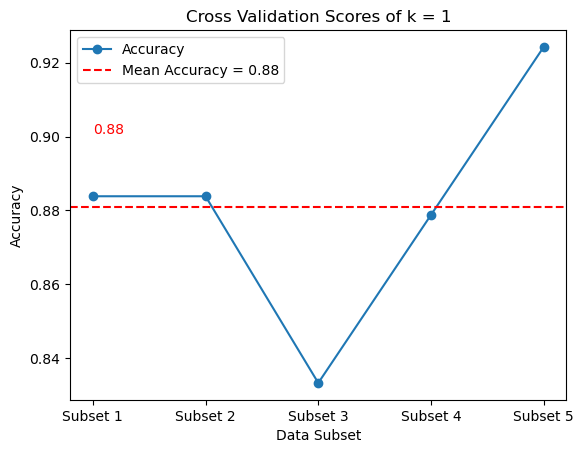

In [430]:
cv_subsets = [f"Subset {i}" for i in range(1,6)]
plt.plot(cv_subsets, scores, label='Accuracy', marker='o', color='tab:blue')
plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean Accuracy = {mean_score:.2f}')
plt.annotate(f'{mean_score:.2f}', xy=(0, mean_score), xytext=(0, mean_score+0.02), color='red') 
plt.xlabel('Data Subset')
plt.ylabel('Accuracy')
plt.title('Cross Validation Scores of k = 1')
plt.legend()
plt.show()

### KNN Conclusion 

After hypertuning and crossvalidation I conclude that the KNN gives the best performace when hyperparameter k = 1, and 5-fold Cross-Validation shows that the model has a 88% accuracy on the data.

### AdaBoost

Next model I will be trying is AdaBoost, for the first iteration I choose 50 estimators for the model which is the default.

In [362]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train)

AdaBoostClassifier()

#### Performance

In [364]:
print(f"Train Accuracy: {ada_boost.score(X_train, y_train)}")
print(f"Test Accuracy: {ada_boost.score(X_test, y_test)}")

Train Accuracy: 0.04040404040404041
Test Accuracy: 0.037037037037037035


As the result shows a 4% training accuracy and 3% test accuracy is not a very great result, let's try increasing the number of estimators and see the result.

#### Increasing Estimators

I will increase the estimator to 150.

In [368]:
ada_boost2 = AdaBoostClassifier(n_estimators = 150)
ada_boost2.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=150)

#### Performance

In [369]:
print(f"Train Accuracy: {ada_boost2.score(X_train, y_train)}")
print(f"Test Accuracy: {ada_boost2.score(X_test, y_test)}")

Train Accuracy: 0.04040404040404041
Test Accuracy: 0.037037037037037035


Increasing the number of estimators doesn't increase the accuracy of the model.

#### Hypertuning Estimators

I will try out a wide range of estimator numbers to see if they make any difference if not then next step is to try hypertuning the learning_rate.

In [371]:
ab_lst = []
ab_train_accuracy = []
ab_test_accuracy = []
for i in range(1, 500, 10):
    m = AdaBoostClassifier(n_estimators=i)
    m.fit(X_train, y_train)
    ab_train_accuracy.append(m.score(X_train, y_train))
    ab_test_accuracy.append(m.score(X_test, y_test))
    ab_lst.append(m)



#### Result

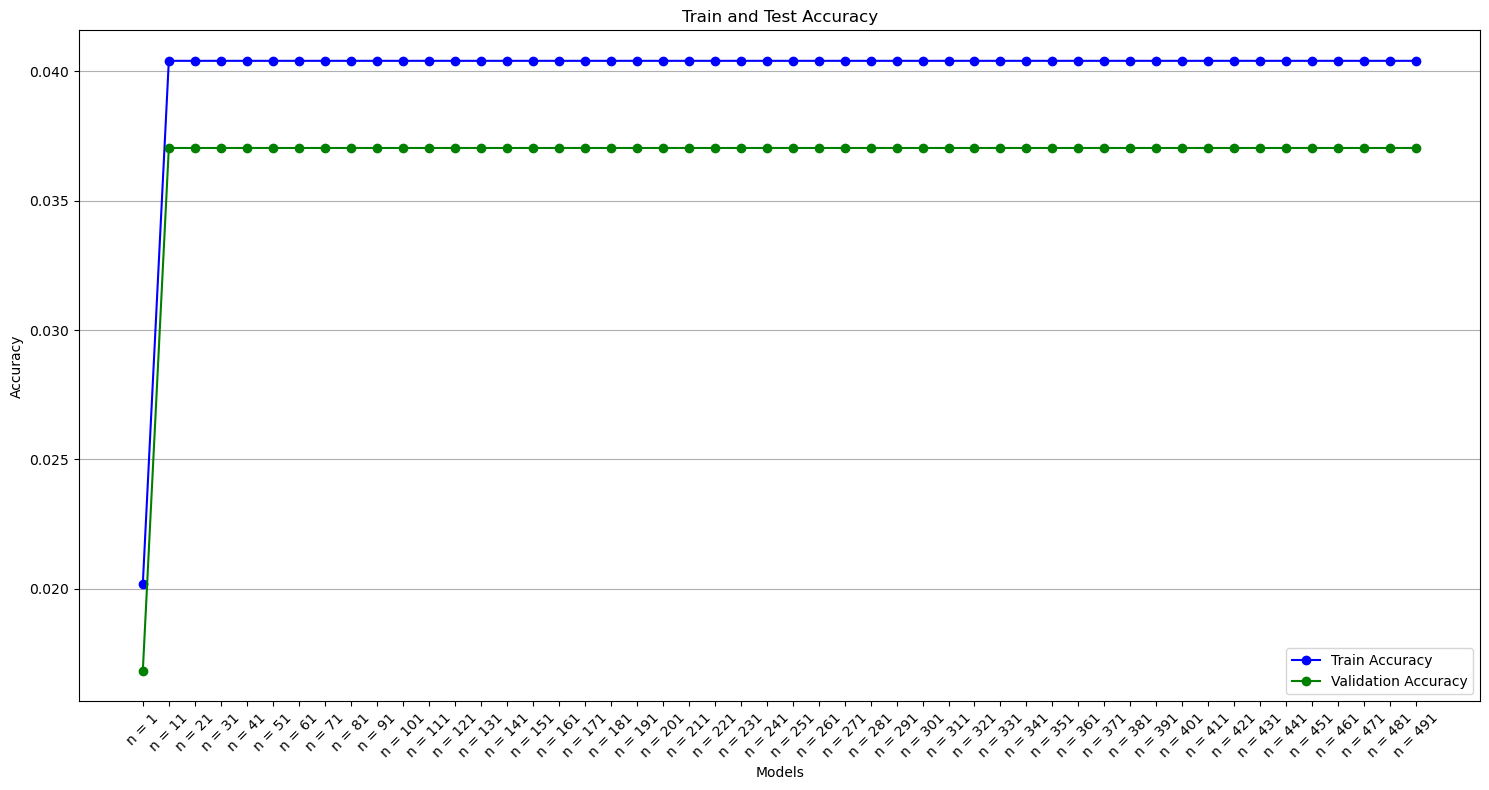

In [373]:
models = [f'n = {i}' for i in range(1, 500, 10)]
plt.figure(figsize=(15, 8))

plt.plot(models, ab_train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, ab_test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

#### Analysis 
Increasing the number of estimator after n_etimators > 10 isn't showing improved preformance. Next let's hypertune the learning rate.

#### Hypertuning Learning Rate

I will tune the learning rate between value 0.01 to 1, 1 is the default learning rate. I will keep the n_estimators to default which is 50.

In [376]:
ab_lst = []
ab_train_accuracy = []
ab_test_accuracy = []
for i in np.arange(0.01, 1.0, 0.1):
    m = AdaBoostClassifier(learning_rate=i)
    m.fit(X_train, y_train)
    ab_train_accuracy.append(m.score(X_train, y_train))
    ab_test_accuracy.append(m.score(X_test, y_test))
    ab_lst.append(m)

#### Result

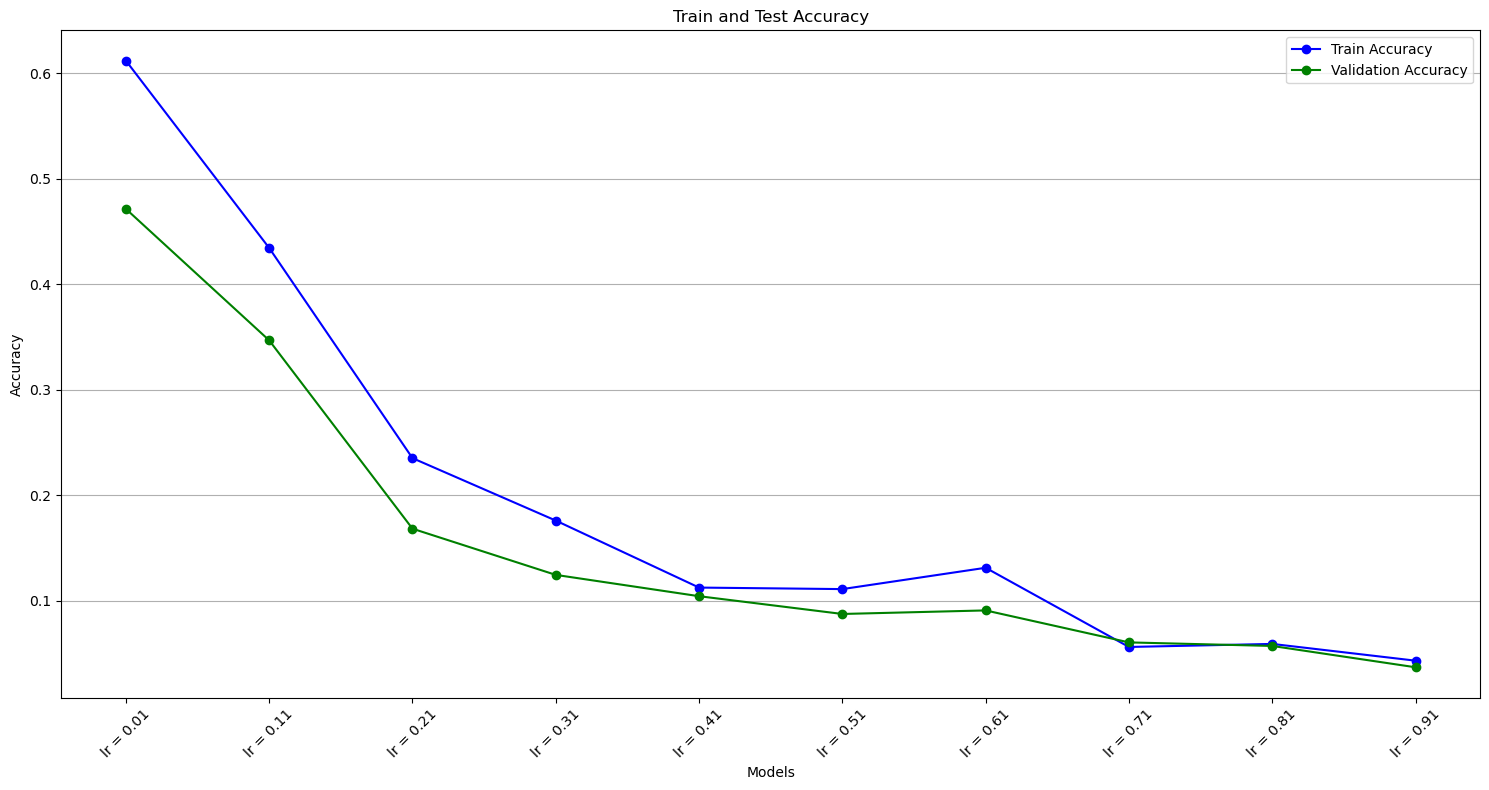

In [378]:
models = [f'lr = {i:.2f}' for i in np.arange(0.01, 1.0, 0.1)]
plt.figure(figsize=(15, 8))

plt.plot(models, ab_train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, ab_test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

#### Analysis

Having a low learning rate of 0.01 is giving the best result till now, train accuracy above 60% and test accuracy above 40% which is way better than 4% and 3% accuray. The weak learners correcting 0.01 percent residual error of its previous step is showing better results.

#### Hypertuning estimators with low learning rate

With this new learning rate let's again try out different number of estimators.

In [379]:
ab_lst = []
ab_train_accuracy = []
ab_test_accuracy = []
for i in range(1, 500, 10):
    m = AdaBoostClassifier(n_estimators=i, learning_rate = 0.01)
    m.fit(X_train, y_train)
    ab_train_accuracy.append(m.score(X_train, y_train))
    ab_test_accuracy.append(m.score(X_test, y_test))
    ab_lst.append(m)

#### Result

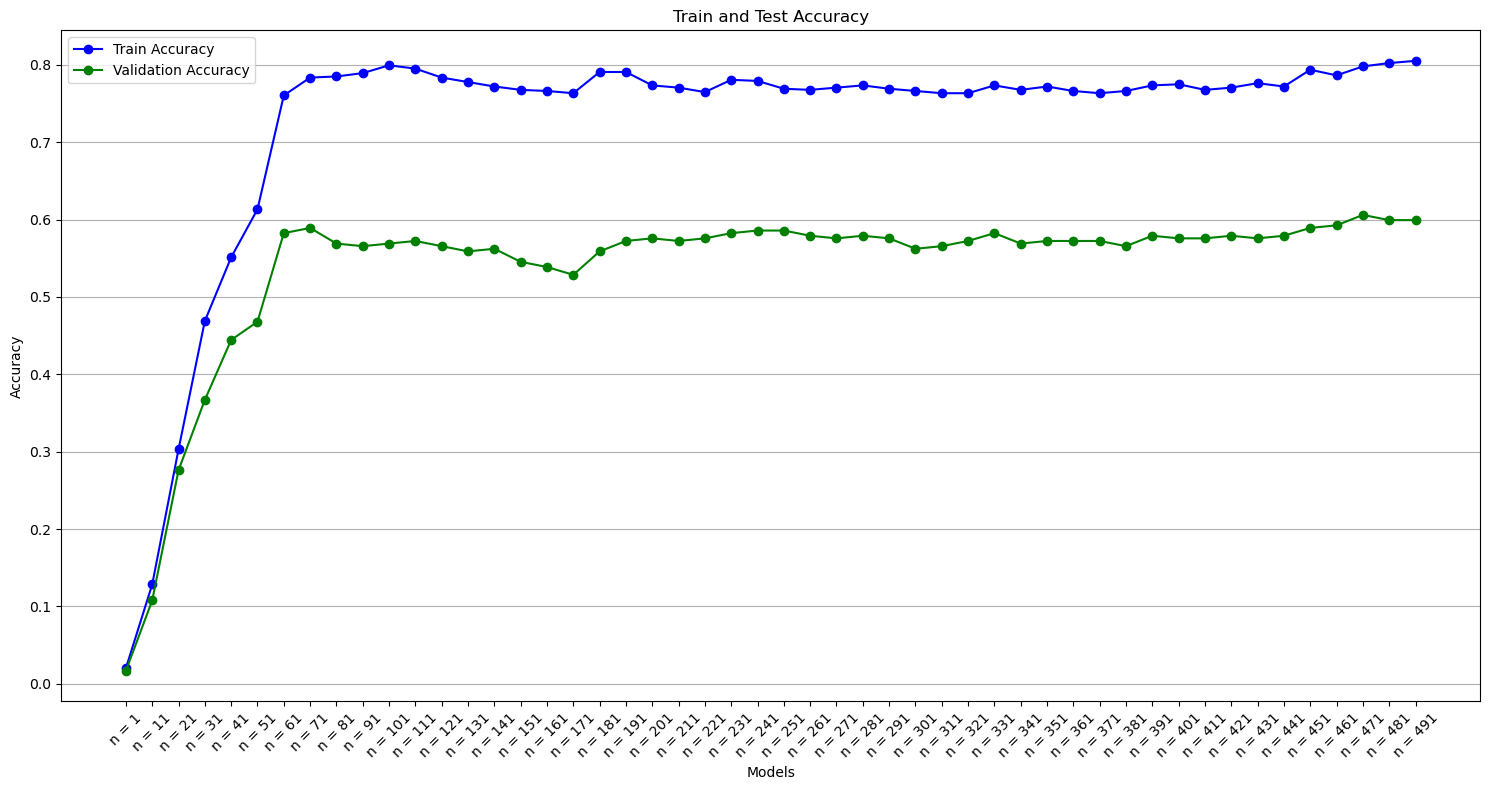

In [380]:
models = [f'n = {i}' for i in range(1, 500, 10)]
plt.figure(figsize=(15, 8))

plt.plot(models, ab_train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, ab_test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

#### Analysis

The effect of the learning rate = 0.01 is roughly showing the same performance after n > 60. In the next step lets reduce the learning rate as the estimators increase.

#### Hypertuning n_estimators and learning_rate

I will start the learning rate from 0.01 and incrementally decrease it with a decay rate every iteration, and decrease the decay rate every 10th iteration for 20 iterations.

In [416]:
# A exponent magnitude calculator for rounding the learning rate after substraction
def count_exponent_magnitude(f):
    
    s = "{:.15e}".format(f)
    
    exponent = int(s.split('e')[1])
    
    return abs(exponent)

ab_lst = []
ab_train_accuracy = []
ab_test_accuracy = []
lr = 0.1
dr = 0.01
lrs = []
for i in range(1, 200, 10):
    if (lr - dr) == 0: 
        dr *= 0.1    
    lr -= dr
    lr = round(lr, count_exponent_magnitude(dr))
    lrs.append(lr)
    m = AdaBoostClassifier(n_estimators=i, learning_rate = lr)
    m.fit(X_train, y_train)
    ab_train_accuracy.append(m.score(X_train, y_train))
    ab_test_accuracy.append(m.score(X_test, y_test))
    ab_lst.append(m)

#### Result

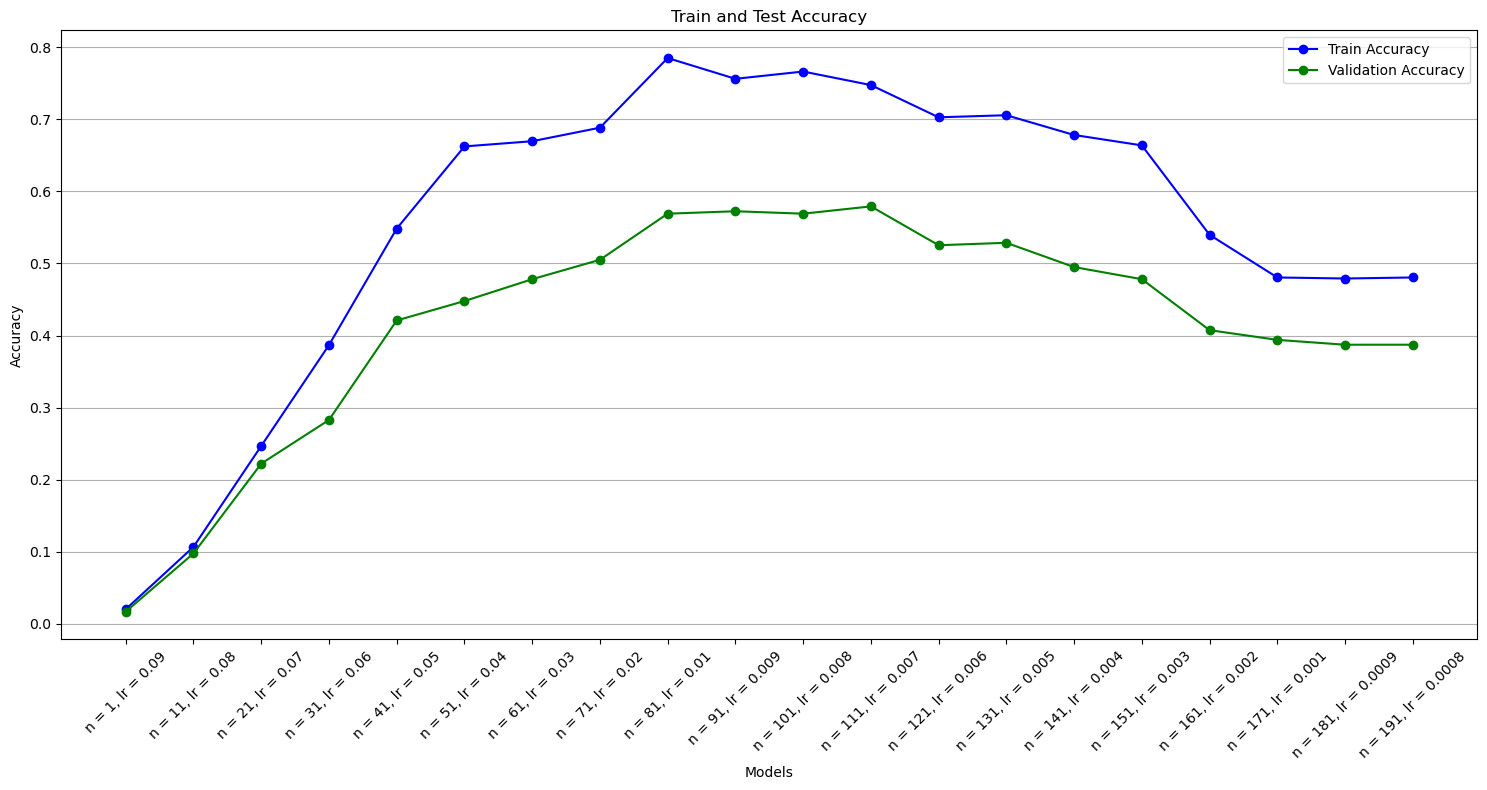

In [417]:
names = [i for i in range(1, 200, 10)]
lrnums = [lrs[i] for i in range(0, 20)]
models = [f'n = {m}, lr = {i}' for m,i in zip(names, lrnums)]
plt.figure(figsize=(15, 8))

plt.plot(models, ab_train_accuracy, label='Train Accuracy', marker='o', color='blue')
plt.plot(models, ab_test_accuracy, label='Validation Accuracy', marker='o', color='green')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(rotation=45)  
plt.legend()

plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

#### Analysis

The best choice for the n_estimators in this plot is 70 because it has the highest train and test accuracy, with a learning rate between ${1 * 10^{-2}}$, but as per the last experiment any number of n_estimator above 60 and a learning rate of 0.01 has approximately the same performance, in this experiment we can definitely say that 0.01 is the optimal choice as a learning rate as it gives the best perfroming model, and from the last experiment we can conclude that optimal choice for n_estimator is 60.

#### Using the best AdaBoost Model

The best AdaBoost Model is a model with learning rate = 0.01 and n_estimator = 60, let us take a closer look at its performance.

In [421]:
best_ada_boost = AdaBoostClassifier(n_estimators=60, learning_rate = 0.01)
best_ada_boost.fit(X_train, y_train)
print(f"Train Accuracy: {best_ada_boost.score(X_train, y_train)}")
print(f"Test Accuracy: {best_ada_boost.score(X_test, y_test)}")

Train Accuracy: 0.7518037518037518
Test Accuracy: 0.5824915824915825


#### Analysis

The current model is now performing way better than the initial model, but AdaBoost is not showing same performance as KNN. To get an even more reliable measure of the model let's cross validate it.

#### Cross-Validating the best AdaBoost Model


In [427]:
cv_best_ada_boost = AdaBoostClassifier(n_estimators=60, learning_rate = 0.01)
cv_ada_scores = cross_val_score(cv_best_ada_boost, feX, y, cv=5)
ada_mean_score = cv_ada_scores.mean()

#### Result

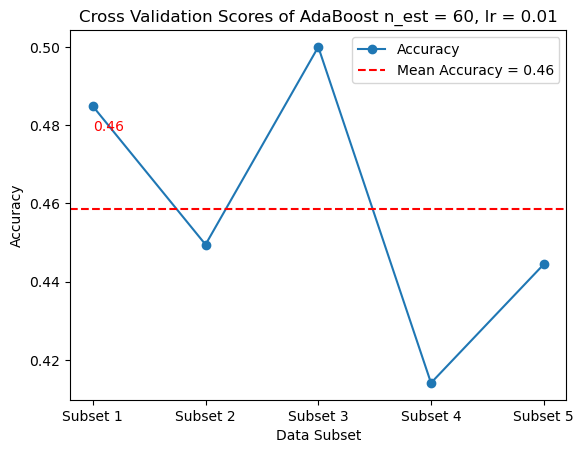

In [428]:
cv_subsets = [f"Subset {i}" for i in range(1,6)]
plt.plot(cv_subsets, cv_ada_scores, label='Accuracy', marker='o', color='tab:blue')
plt.axhline(ada_mean_score, color='red', linestyle='--', label=f'Mean Accuracy = {ada_mean_score:.2f}')
plt.annotate(f'{ada_mean_score:.2f}', xy=(0, ada_mean_score), xytext=(0, ada_mean_score+0.02), color='red') 
plt.xlabel('Data Subset')
plt.ylabel('Accuracy')
plt.title('Cross Validation Scores of AdaBoost n_est = 60, lr = 0.01')
plt.legend()
plt.show()

#### Analysis

The mean cv score of the best AdaBoost model is 46% which is almost half of the best KNN model score.

### AdaBoost Conclusion

The AdaBoost model doesn't seem to be a good fit for this Dataset, but in the process of fitting the data to AdaBoost model the combination of n_est = 60 and lr = 0.01 was found to be the best performing model with 46% accuracy.

### Result and Analysis 

#### Summary
In the endeavor to classify the leaf species, we experimented with KNN and AdaBoost algorithms. While KNN achieved an accuracy of 88%, AdaBoost lagged, reaching only 46% accuracy.

- __KNN__:

Started with a low k value leading to overfitting. Data imbalance in train-test split exacerbated the issue.
- Solutions Applied: Balanced the train-test split, reducing overfitting. Hyperparameter tuning indicated k=1 as optimal.
- Performance: Achieved a stable model accuracy of 88% using 5-fold Cross-Validation.

- __AdaBoost__:

A default model with 50 estimators had a mere 4% accuracy. Increasing n_estimators further degraded performance.
- Solutions Applied: Hyperparameter tuning showed the optimal learning rate as 0.01. With this learning rate, the best n_estimators value was found to be 60.
- Performance: Despite the tuning, the best AdaBoost model was significantly outperformed by KNN, suggesting the dataset might not be suitable for AdaBoost or requires a different approach.


#### Model Metrics


As the goal of the model is to correctly classify the each leaf in the dataset with the appropriate species. For analysis sake I have used only mean accuracy for analyzing the model even with cross-validation. But the other metrics such as precision and recall are also important for analyzing the models, because I would like to know what is the rate of the model predicting true positives if I am dealing with a potentially poisonous plant, and if a poisonous plant is mistaken for a non-poisonous plant it would be very dangerous. Recall score is also important as I would like to know how many positives I am predicting out of real positives.

#### KNN Confusion Matrix

I will plot the whole confusion matrix becuase it is too big to visually analyze, instead I will count the overall True Positives, False Positives, False Negatives predicted by the model

In [525]:
knn_pred = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_pred)

In [526]:
TP_overall = np.diag(cm).sum()
FP_overall = knn_cm.sum(axis=0).sum() - TP_overall
FN_overall = knn_cm.sum(axis=1).sum() - TP_overall

values = [TP_overall, FP_overall, FN_overall]
total = sum(values)
labels = ['TP', 'FP', 'FN']

#### Result

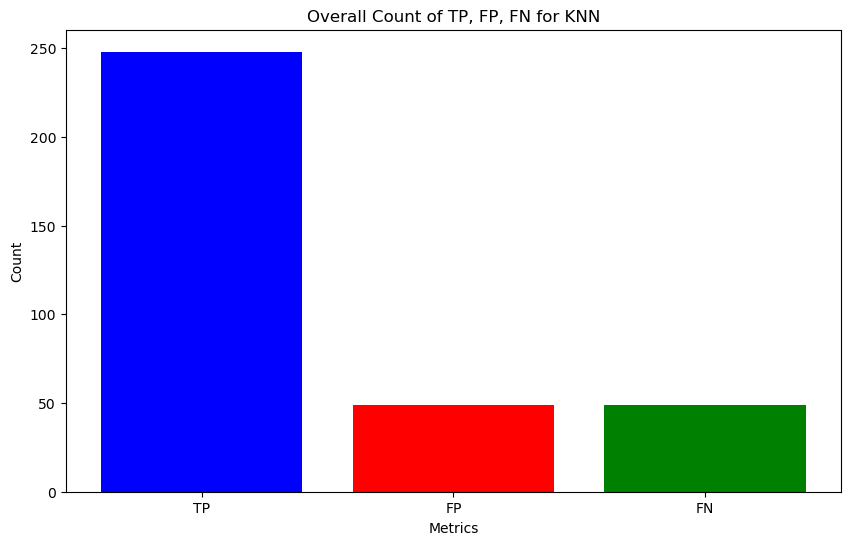

In [531]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Overall Count of TP, FP, FN for KNN')
plt.show()

#### Analysis 
The FP and FN metrics are equal to 49, and TP rate is 248.

#### AdaBoost Confusion Matrix

Count the overall True Positives, False Positives, False Negatives predicted by the AdaBoost Model

In [520]:
ada_pred = best_ada_boost.predict(X_test)
ada_cm = confusion_matrix(y_test, ada_pred)

In [535]:
TP_overall = np.diag(ada_cm).sum()
FP_overall = ada_cm.sum(axis=0).sum() - TP_overall
FN_overall = ada_cm.sum(axis=1).sum() - TP_overall

values = [TP_overall, FP_overall, FN_overall]
total = sum(values)
labels = ['TP', 'FP', 'FN']

#### Result

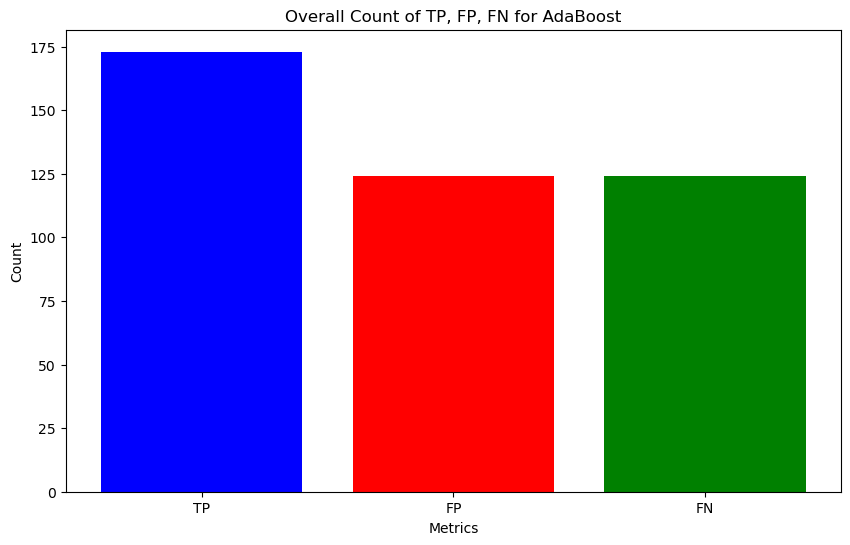

In [534]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Overall Count of TP, FP, FN for AdaBoost')
plt.show()

#### Analysis 
The FP and FN metrics are equal to 124, and TP rate is 173.

#### Visualising Different Metrics for both models

What I want to do is visualise different metrics such as precision, recall and accuracy on the test set for both the models.

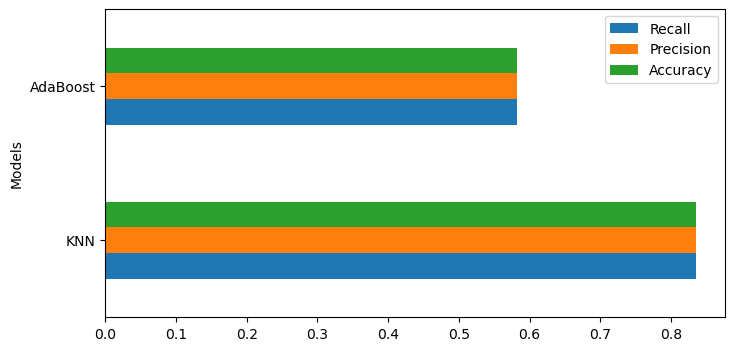

In [536]:
pred_data = [["KNN", recall_score(y_test, knn_pred, average = "micro"), precision_score(y_test, knn_pred, average = "micro"), accuracy_score(y_test, knn_pred)],
             ["AdaBoost", recall_score(y_test, ada_pred, average = "micro"), precision_score(y_test, ada_pred, average = "micro"), accuracy_score(y_test, ada_pred)]]
             
pred_df = pd.DataFrame(pred_data , columns = ["Models","Recall", "Precision", "Accuracy"])
             
pred_df.plot(x = "Models", y = ["Recall", "Precision", "Accuracy"],  kind="barh",figsize=(8,4))

plt.show()

#### Analysis

The precision, recall and accuracy scores are equal to each other, in both the models. Above 80% for KNN model and above 50% for AdaBoost. 

#### Performing Cross-Validation with different Metrics for both Models

Now I will use the cross-validation with the precision, recall and accuracy metrics.

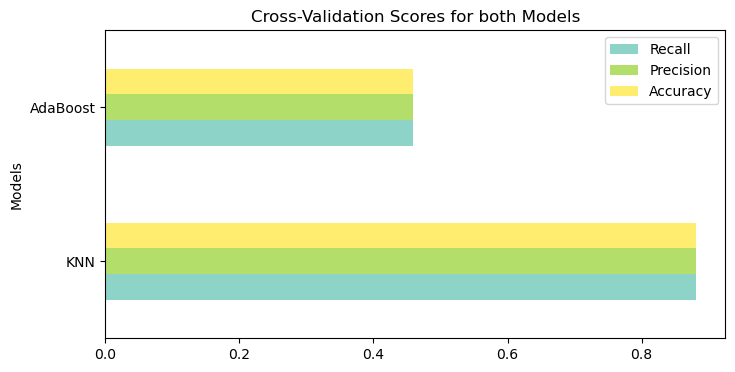

In [477]:
knn_pred = cross_val_predict(cv_knn, feX, y, cv=5)
ada_pred = cross_val_predict(cv_best_ada_boost, feX, y, cv=5)

pred_data = [["KNN", recall_score(y, knn_pred, average = "micro"), precision_score(y, knn_pred, average = "micro"), accuracy_score(y, knn_pred)],
             ["AdaBoost", recall_score(y, ada_pred, average = "micro"), precision_score(y, ada_pred, average = "micro"), accuracy_score(y, ada_pred)]]
             
pred_df = pd.DataFrame(pred_data , columns = ["Models","Recall", "Precision", "Accuracy"])
             
pred_df.plot(x = "Models", y = ["Recall", "Precision", "Accuracy"],  kind="barh",figsize=(8,4), cmap = "Set3")
plt.title("Cross-Validation Scores for both Models")
plt.show()

#### Analysis 

As before the cross-validation model scores for each metric precision, recall and accuracy. Here again we see a 88% score from KNN Model and a 46% score in AdaBoost. The knn model corectly predicts 88% of the real positives correctly, and classifies 88% positives correctly out of all predicted positives.

### Discussion

#### Learning and Takeaways

1. The initial stages of modeling with KNN exhibited overfitting, which is a common challenge in machine learning. The realization that the train-test split was imbalanced underscores the importance of always verifying data distribution, especially when dealing with multiple classes. Balancing the data improved model performance, highlighting the importance of preprocessing steps in modeling.

2. The KNN and AdaBoost models' performances varied significantly with changes in hyperparameters. The choice of k in KNN and the learning rate and number of estimators in AdaBoost were critical. This experience emphasizes the importance of systematic hyperparameter tuning and not relying solely on default values, especially when dealing with complex datasets.

3. The stark difference in performance between KNN and AdaBoost on this dataset was a clear example that not all algorithms are suitable for all types of data. While KNN was able to capture the nuances of the dataset effectively, AdaBoost struggled despite extensive tuning. This could be attributed to the inherent nature of the AdaBoost algorithm or the features of the dataset itself.

#### Possible Changes and Reasons for AdaBoost not performing.

1. The decision boundaries might be too complex for the base learners in AdaBoost to capture effectively.
2. The combination of the chosen base learners and the boosting mechanism might not be correct for this particular dataset, amd needs further experimentation.

### Conclusion 

In this project I developed two models KNN and AdaBoost. With an accuracy of 88%, the KNN model, tuned to k=1, emerged as the clear winner. The struggles with AdaBoost, despite achieving only 46% accuracy, were equally beneficial for learning. They served as a reminder that algorithm selection should be based on data characteristics and problem requirements, and not all algorithms will perform optimally across different datasets.

For future experiments, considering more sophisticated ensemble methods, diving deeper into feature engineering, or even exploring neural networks might be beneficial. Additionally, a more in-depth analysis of the data, incorporating domain knowledge, could help in refining features or preprocessing steps, making algorithms like AdaBoost more effective.